# 1. Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)

In [1]:
#!pip install DiadFit --upgrade 

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
import os
pf.__version__

'0.0.58'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [2]:
MasterFolder=r"C:\Users\charl\Documents\Instruments and calibrations"
DayFolder=MasterFolder + "/UCB_5-10-23"

if not os.path.exists(MasterFolder + '\OUTPUT'):
    os.mkdir(MasterFolder +'\OUTPUT')
if not os.path.exists(MasterFolder + '\OUTPUT'+'\Pickles'):
    os.mkdir(MasterFolder + '\OUTPUT'+'\Pickles')

if not os.path.exists(DayFolder + '\GROUPS'):
    os.mkdir(DayFolder +'\GROUPS')

if not os.path.exists(DayFolder + '\FITOUT'):
    os.mkdir(DayFolder +'\FITOUT')


meta_path=DayFolder +  '\METADATA'
spectra_path=DayFolder + '\SPECTRA'

output_path=MasterFolder +"\OUTPUT"
fitout_path=DayFolder+'\FITOUT'
group_path=DayFolder+'\GROUPS'

filetype='headless_txt'

In [5]:
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='N', 
exclude_str=['diad','L','C'], sort=False)

Ne_files[0:5]

['01 Ne_lines_1.txt',
 '04 Ne_lines_2.txt',
 '08 Ne_lines_3.txt',
 '09 Ne_lines_4.txt',
 '13 Ne_lines_5.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [6]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [7]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1117.086987  1447.564622                1117   

   Entered Pos Line 2  
0                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [8]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne_lines_1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583        3524.0  1447.663174       48252.0  2824.700018   

     Peak2_prom  
0  47552.700018

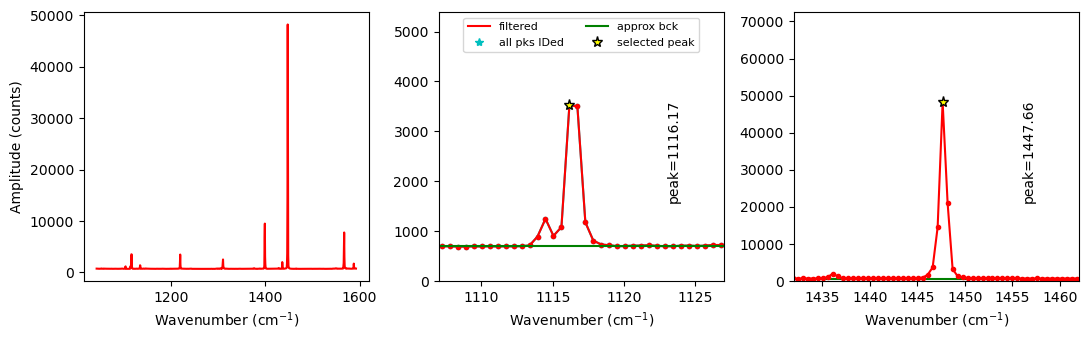

In [9]:
exclude_range_1=None
exclude_range_2=None


Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [10]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [11]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[2, 5],
pk1_sigma=0.6, pk2_sigma=0.5,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-30, -23], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  \
0  01 Ne_lines_1.txt    1447.716132   48954.621218   0.417475      None   

   error_pk2  Peak2_Prop_Lor  pk1_peak_cent  pk1_amplitude  pk1_sigma  \
0          1         0.39026    1116.445554    3954.544227    0.43391   

  pk1_gamma  error_pk1  Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0      None        NaN        0.349996  331.270578  0.997606          NaN   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0          NaN    109.951443      14.89561        124.847052

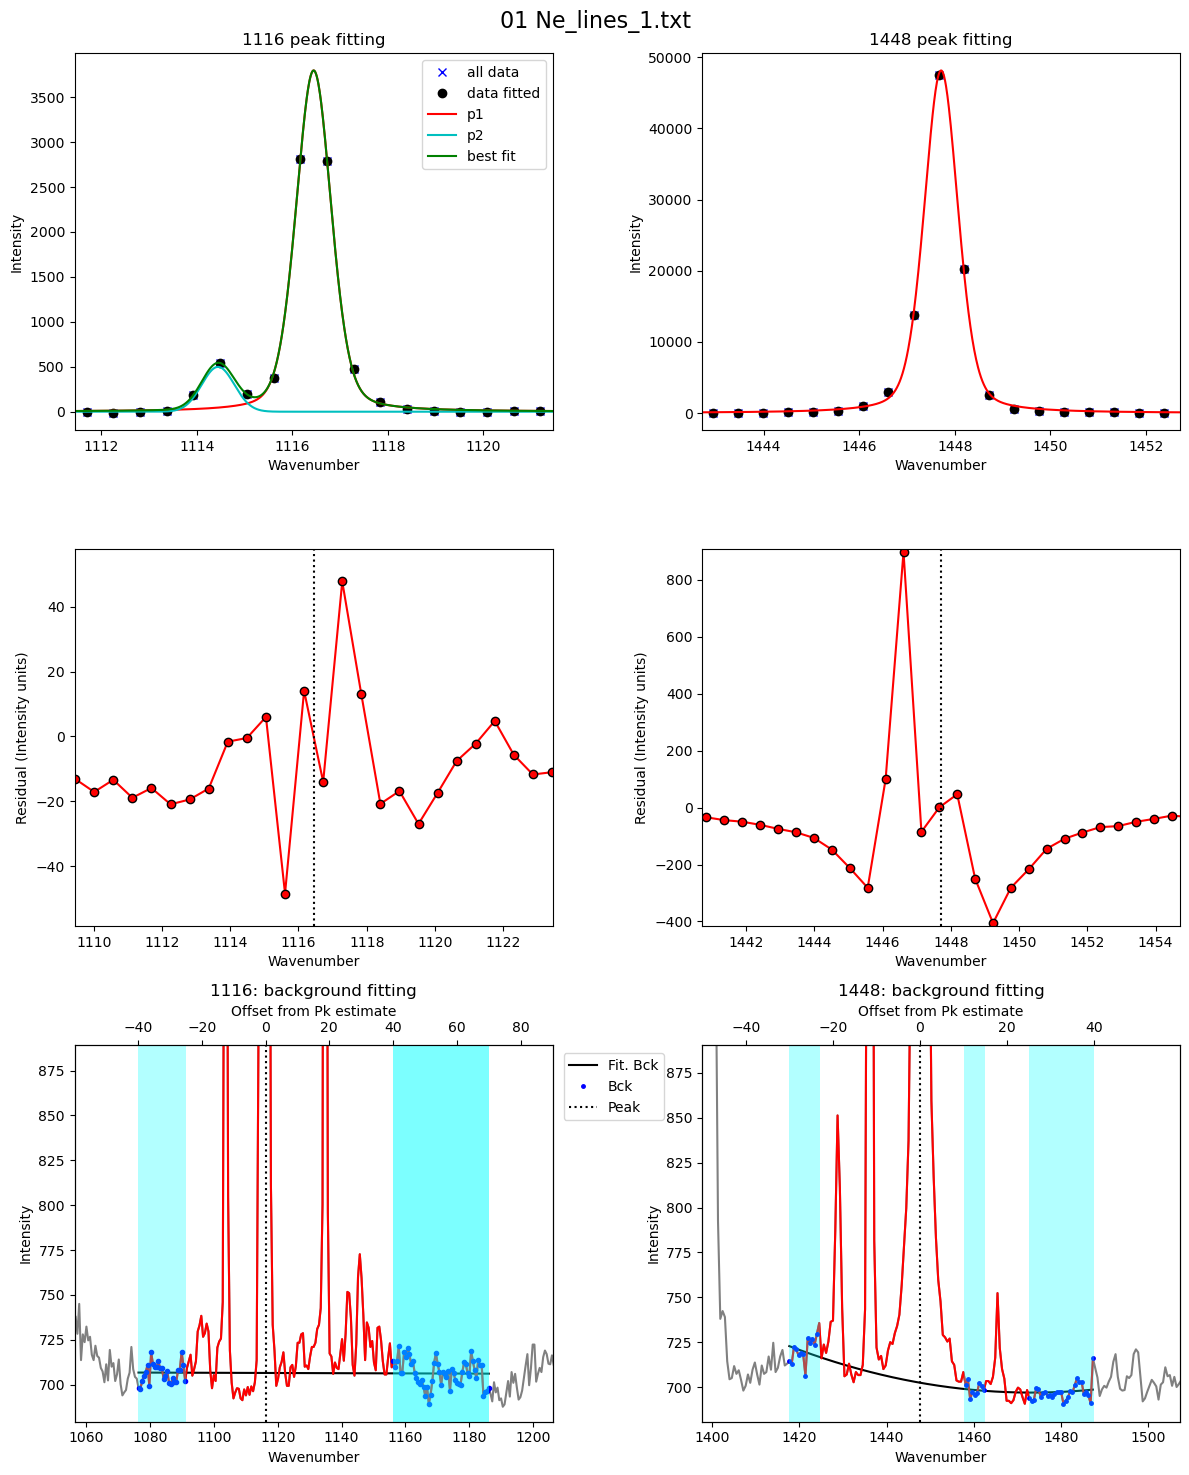

In [12]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=False,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[i], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[i],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[i],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[i],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [13]:
## Update sigma based on this one fit
Ne_Config_tweak=Ne_Config_est
Ne_Config_tweak.pk1_sigma=df_test_params['pk1_sigma'].iloc[0]
Ne_Config_tweak.pk2_sigma=df_test_params['pk2_sigma'].iloc[0]

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/18 [00:00<?, ?it/s]

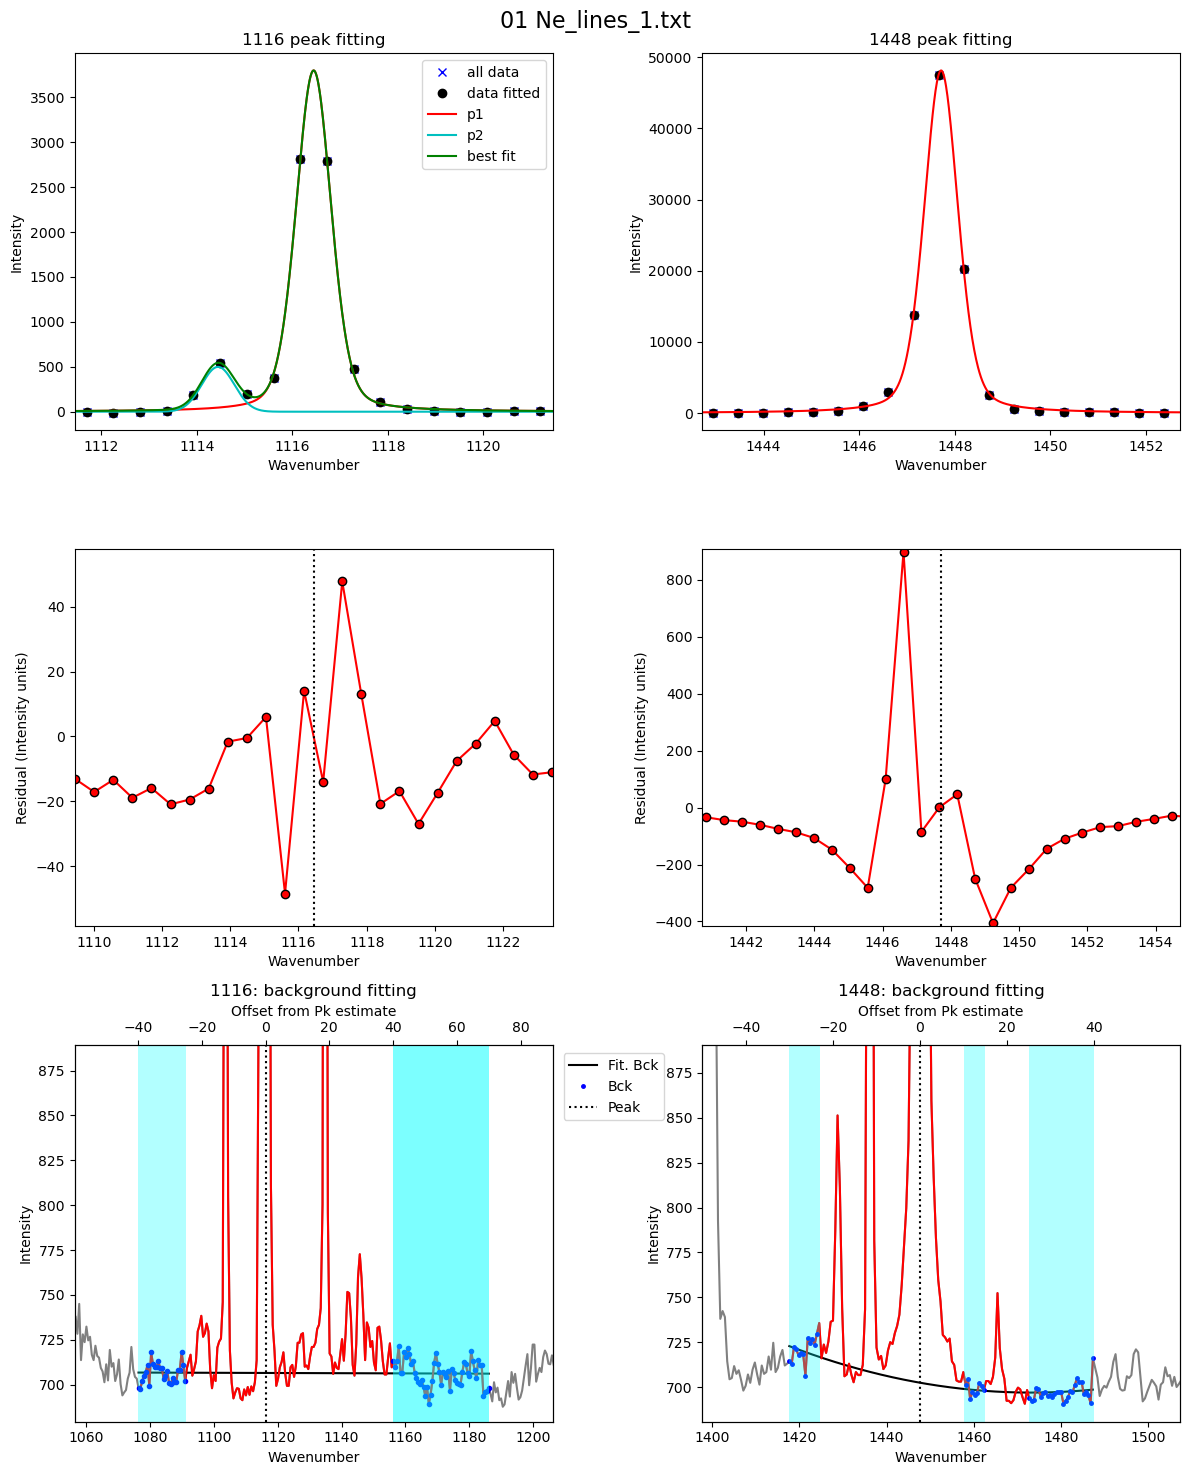

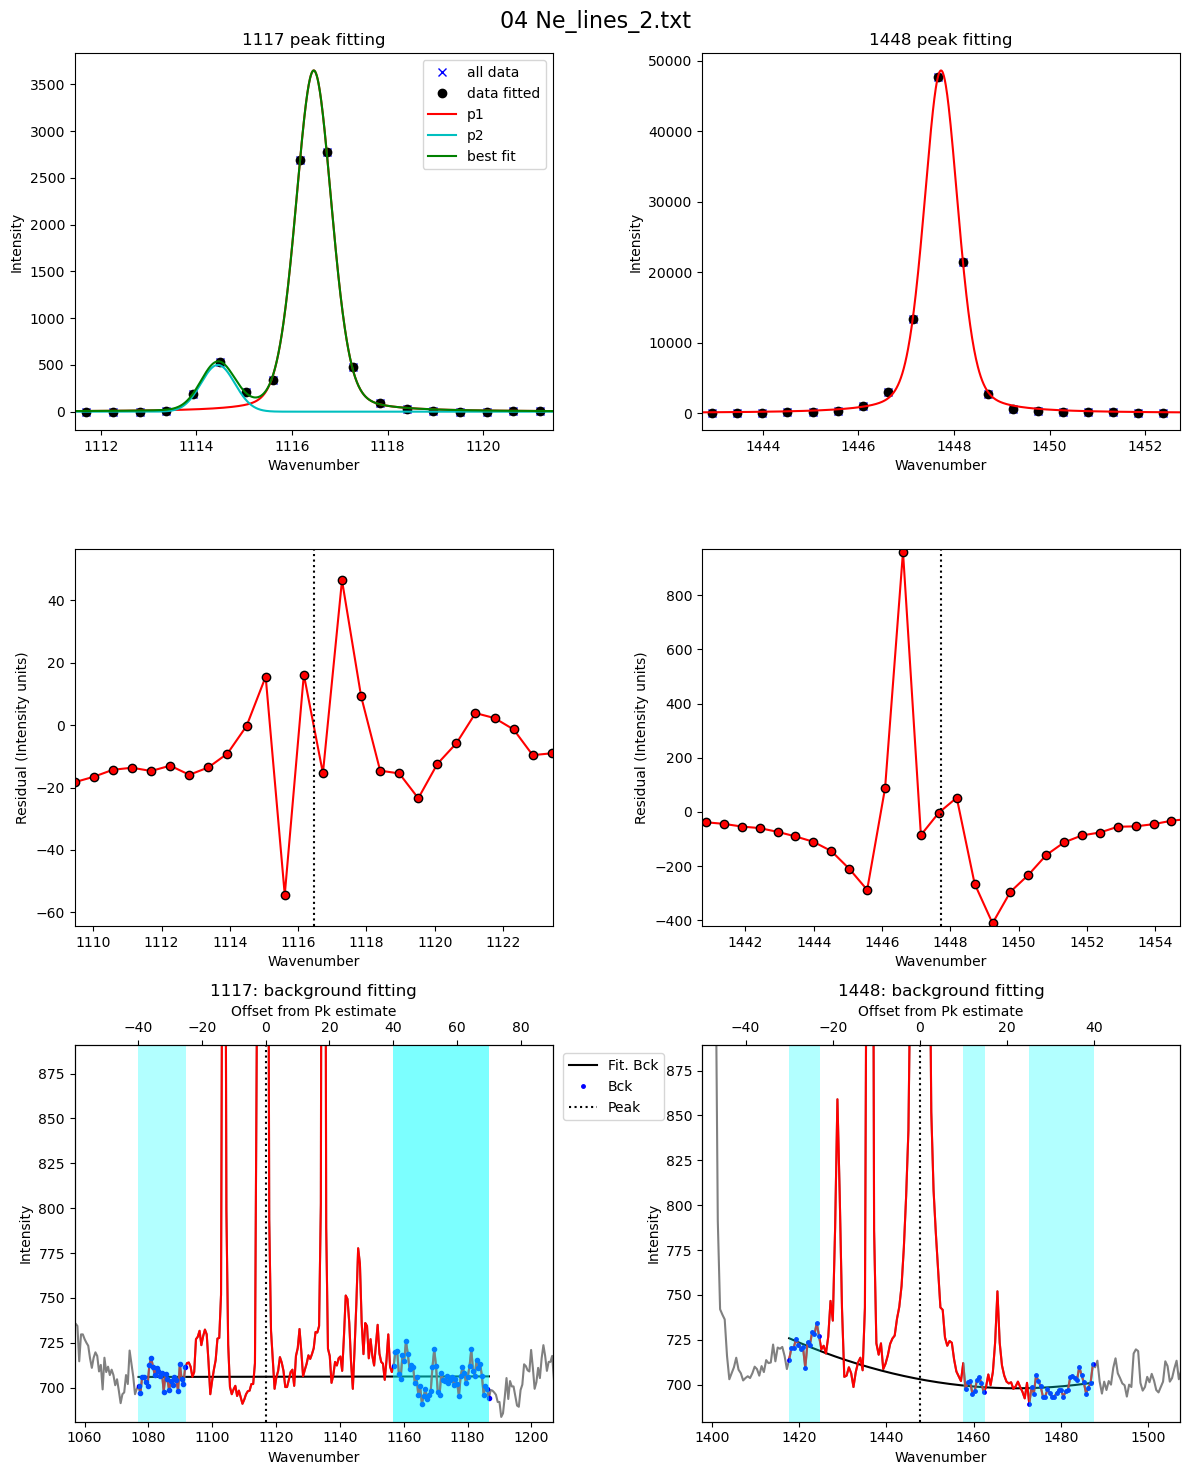

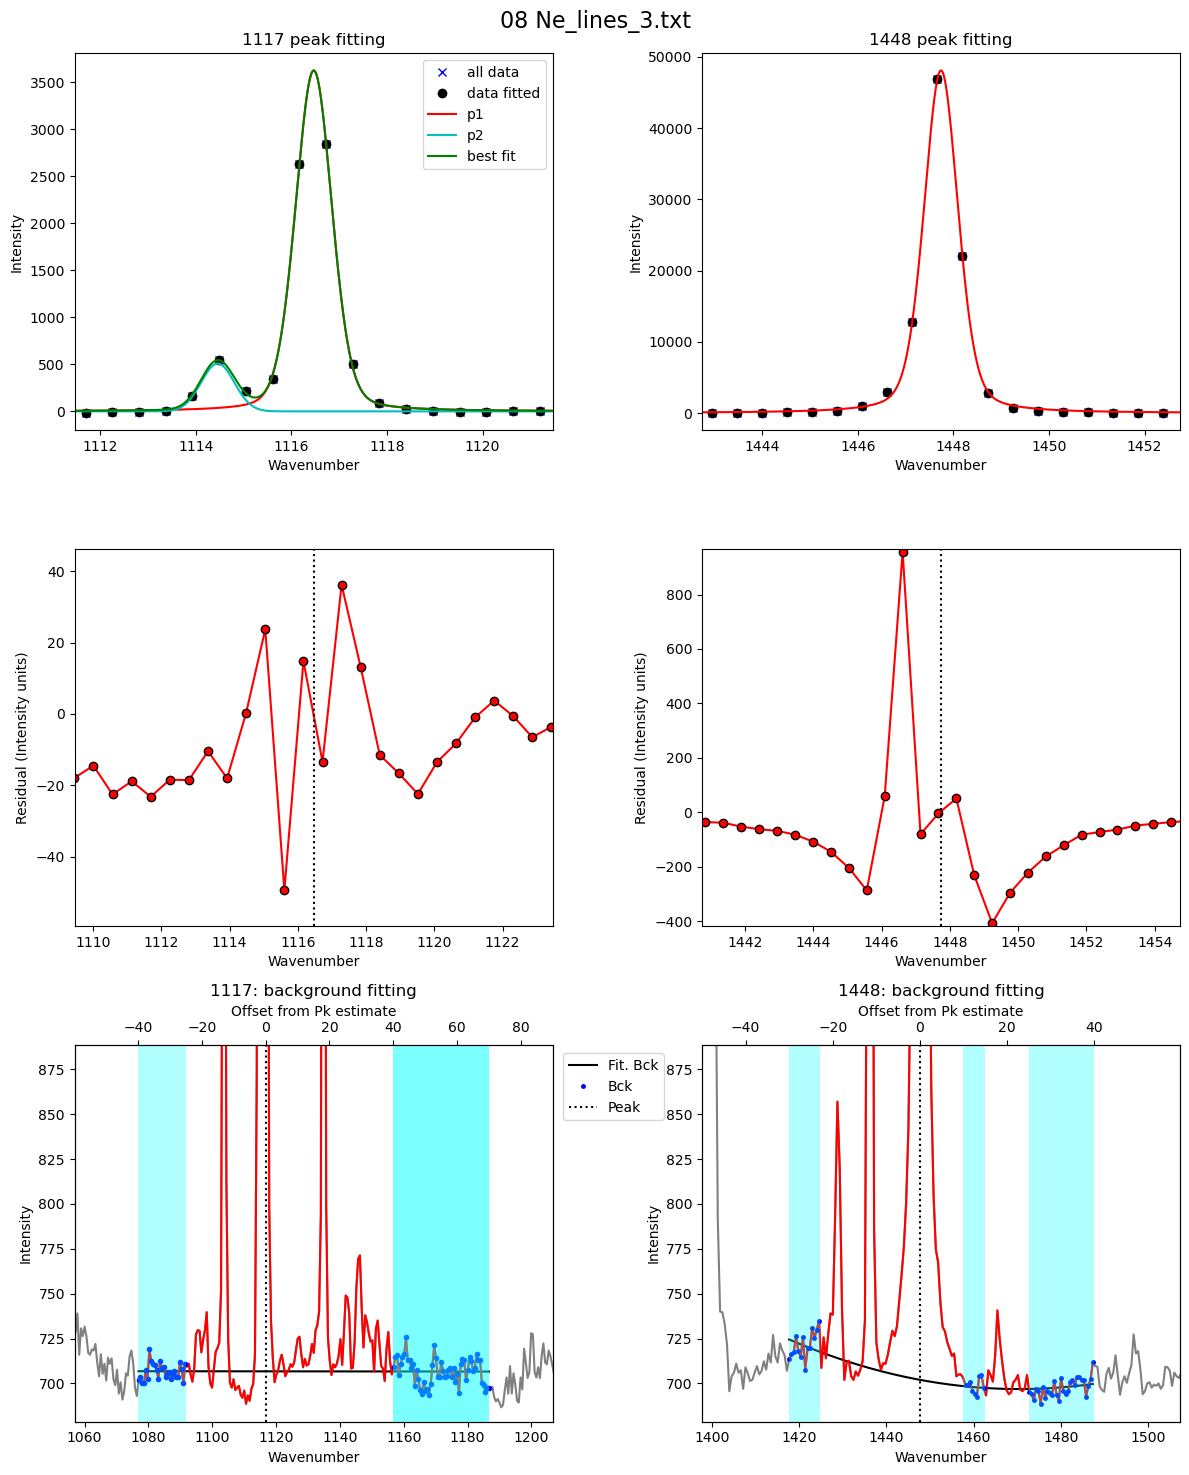

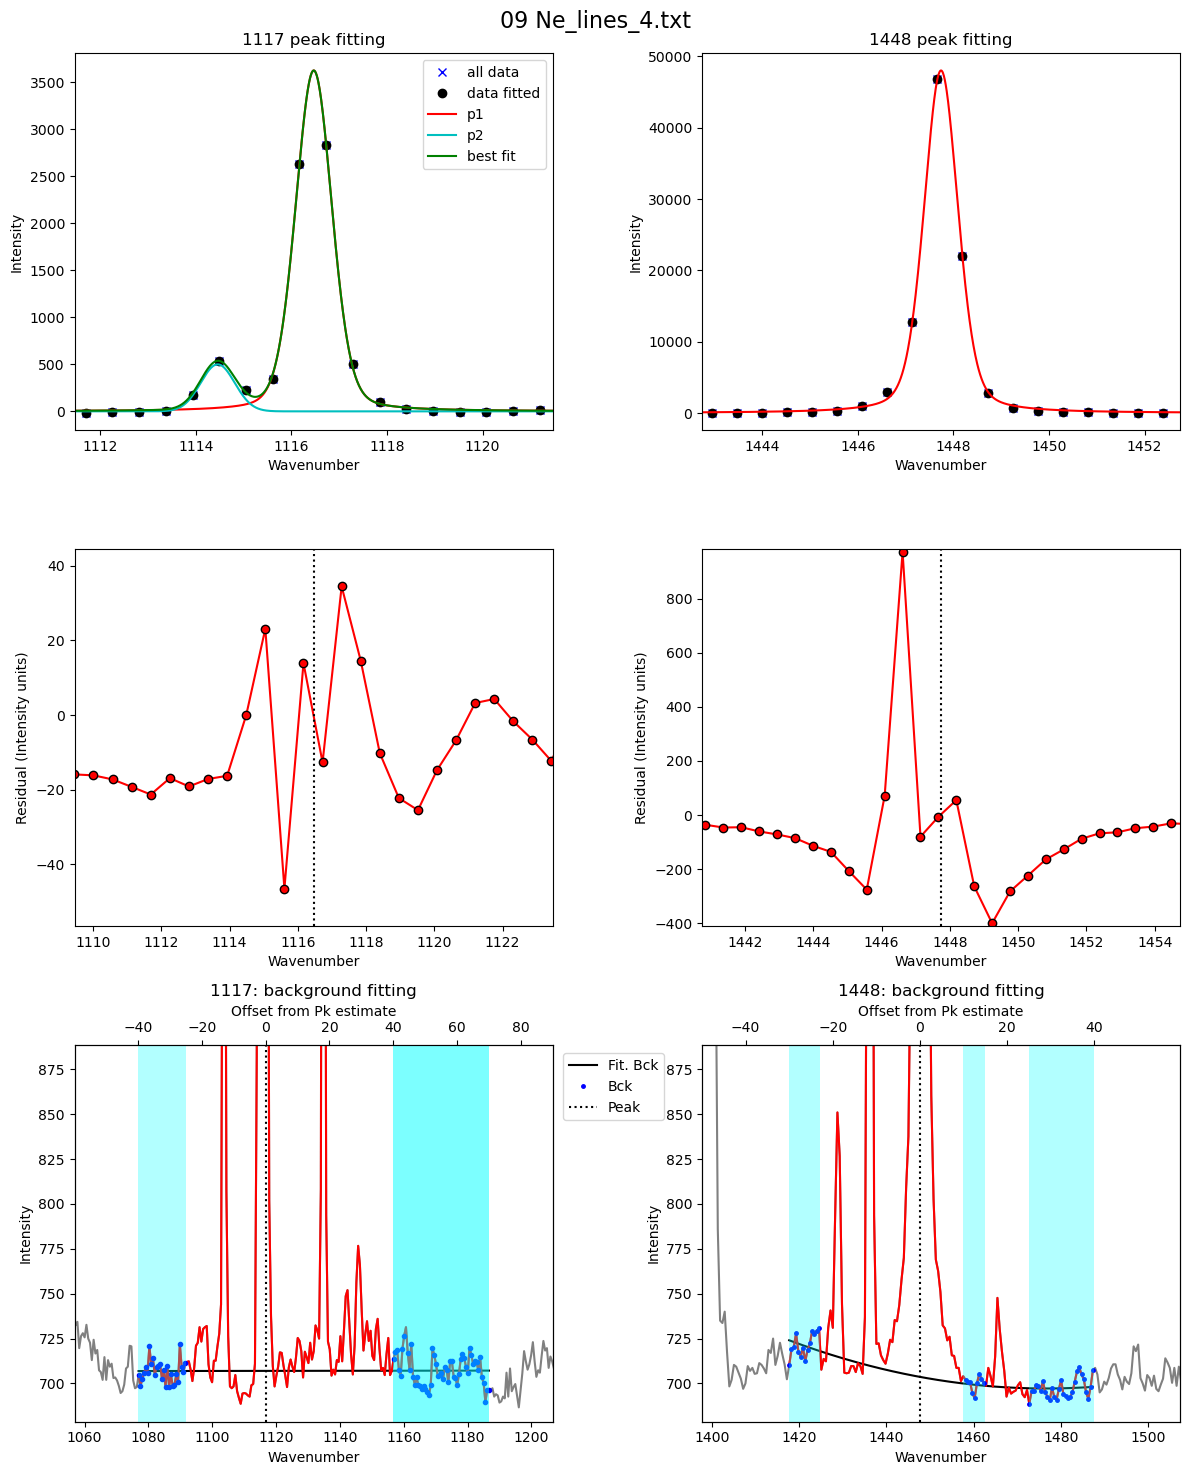

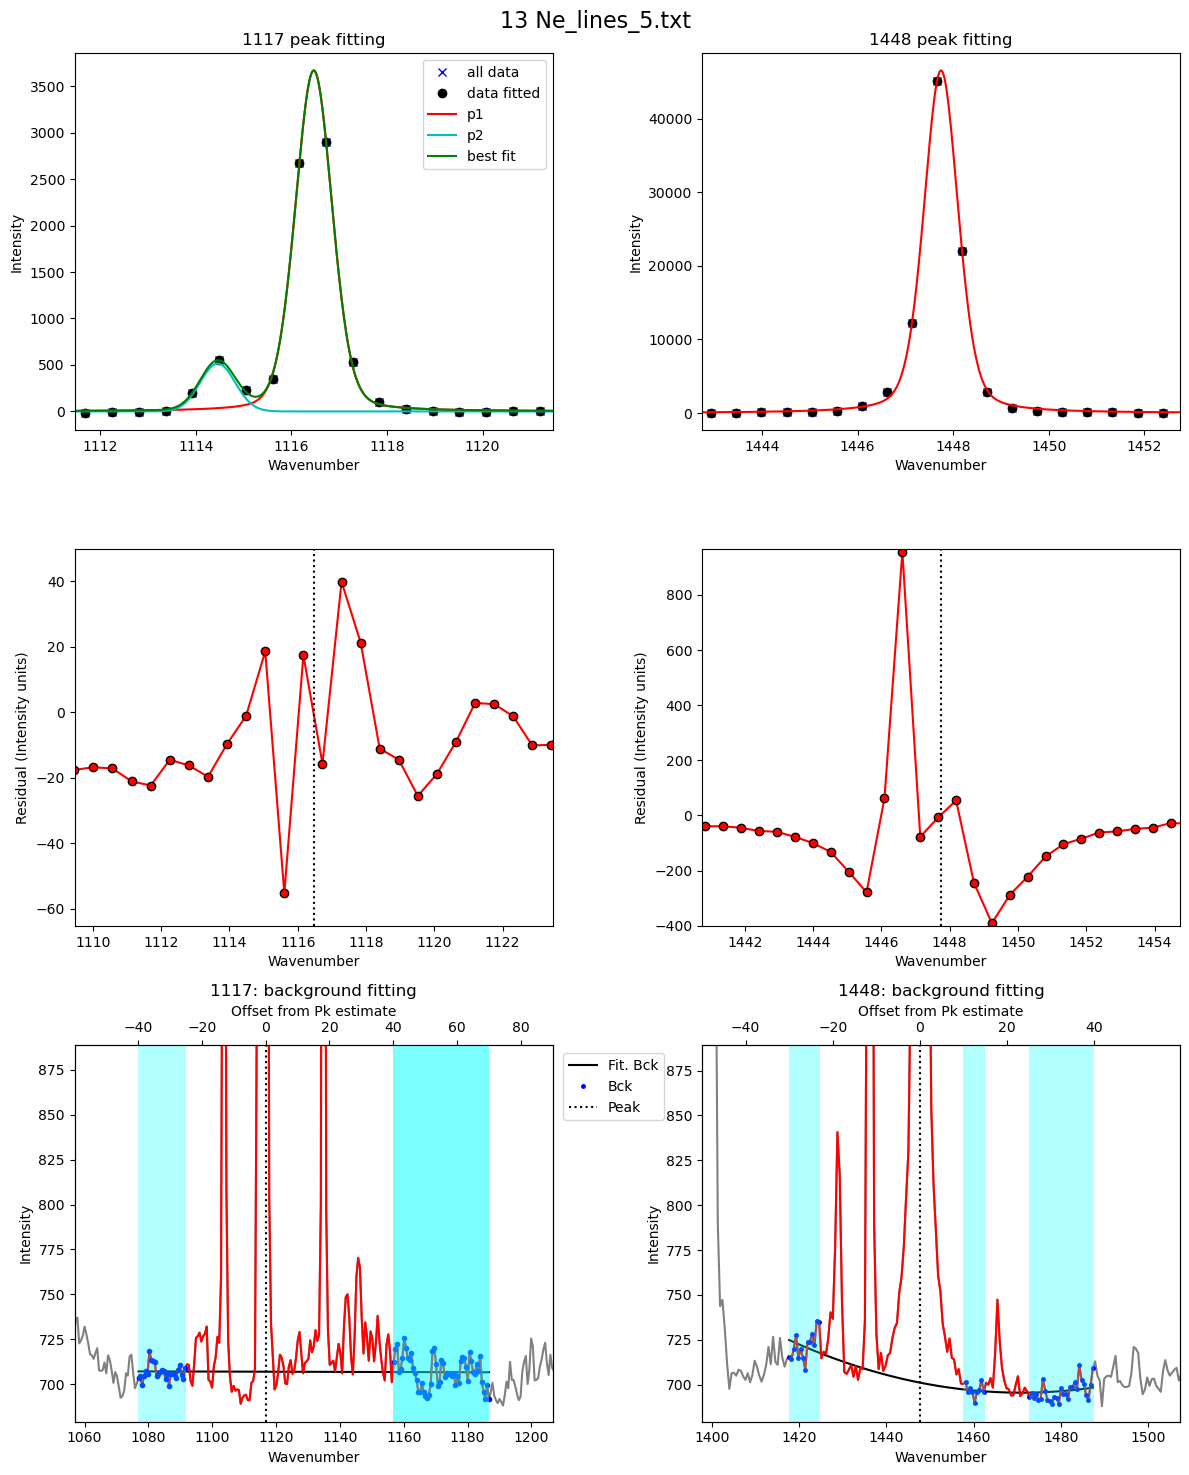

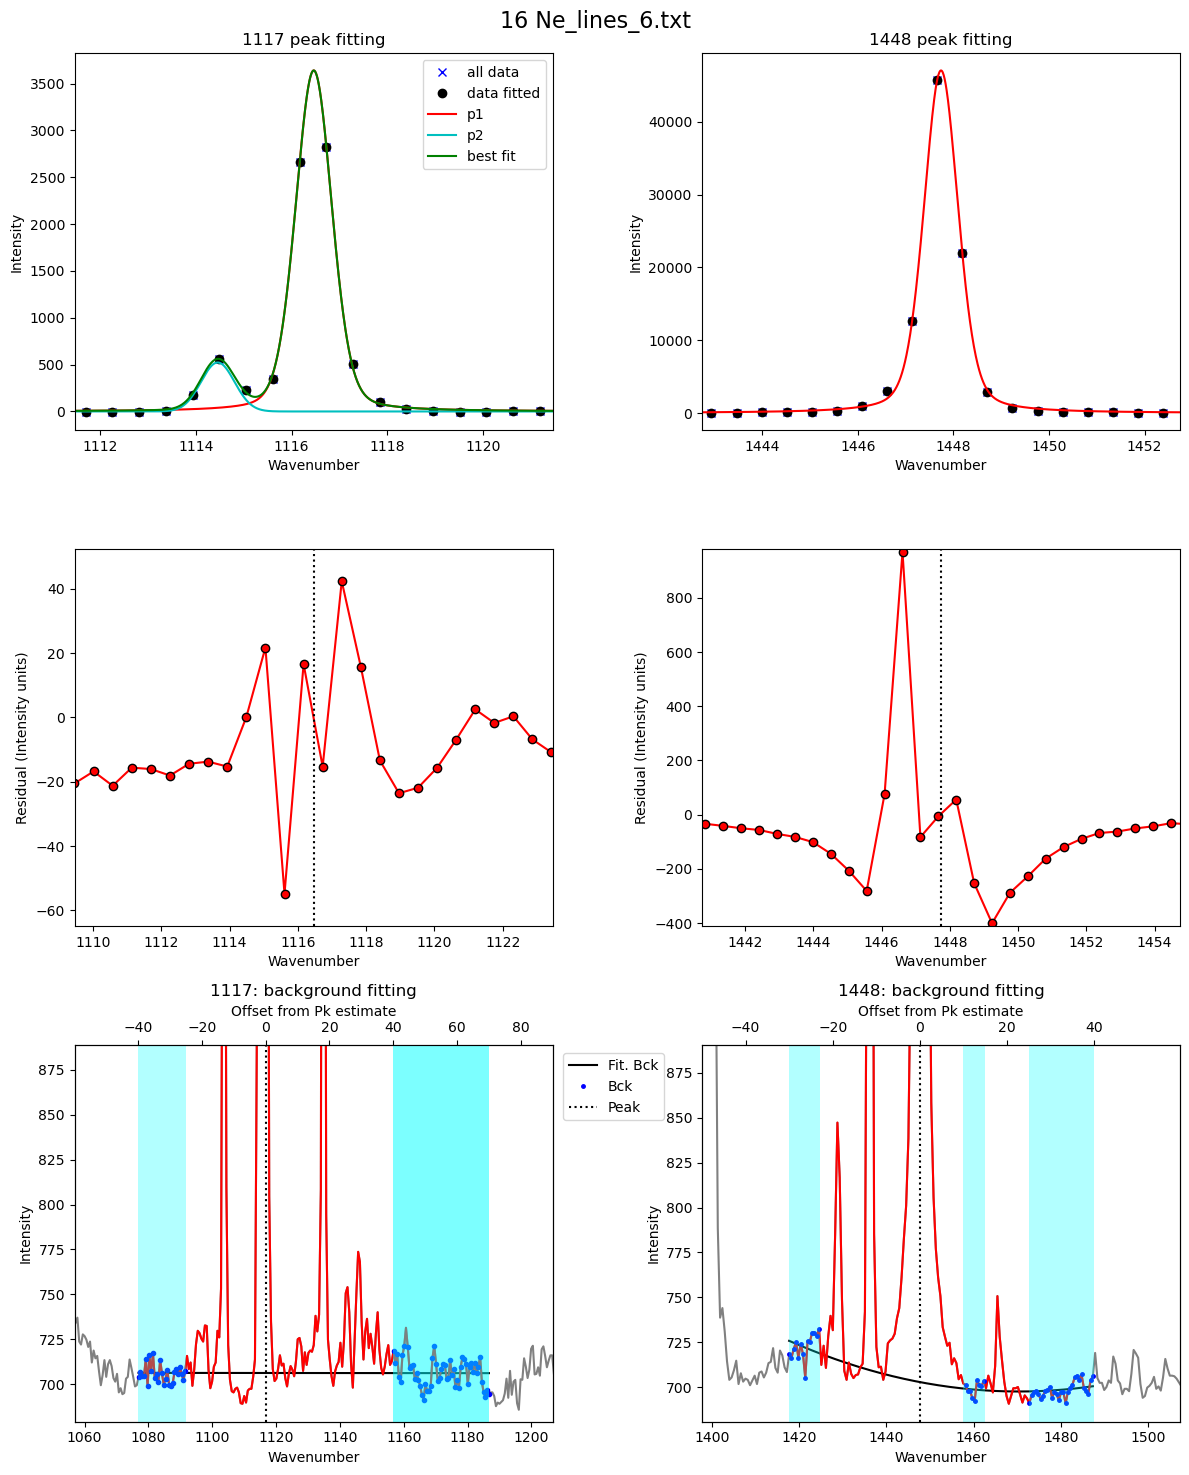

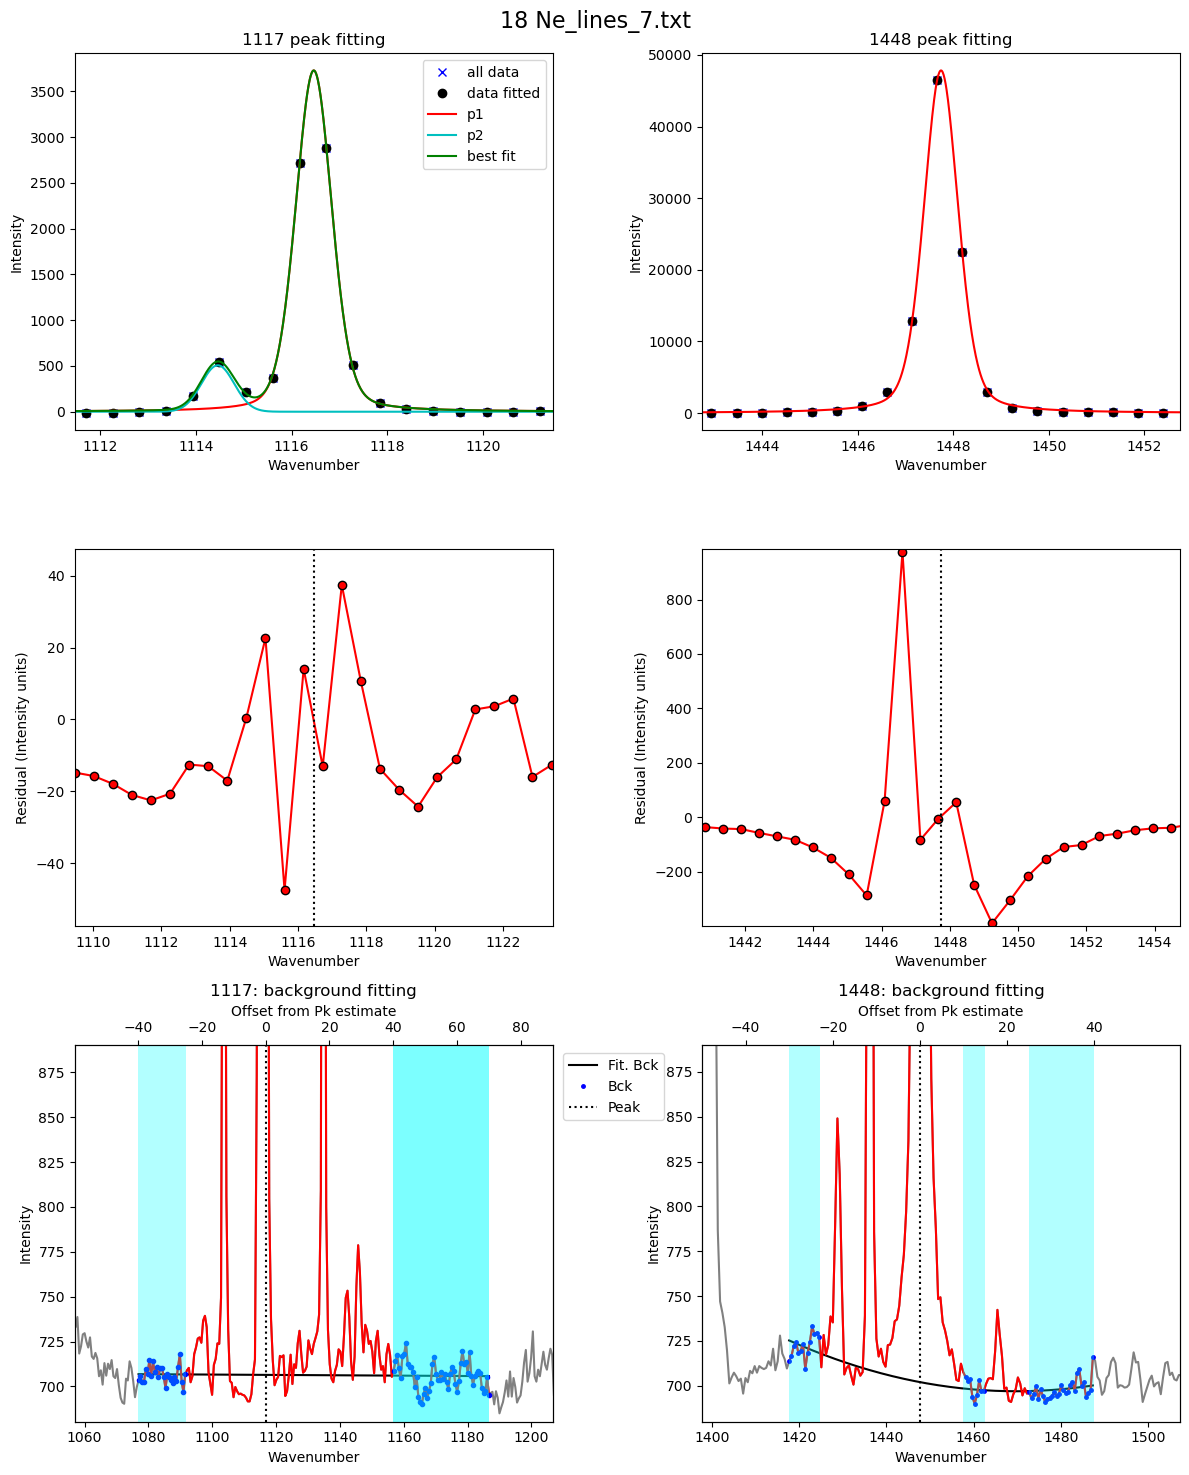

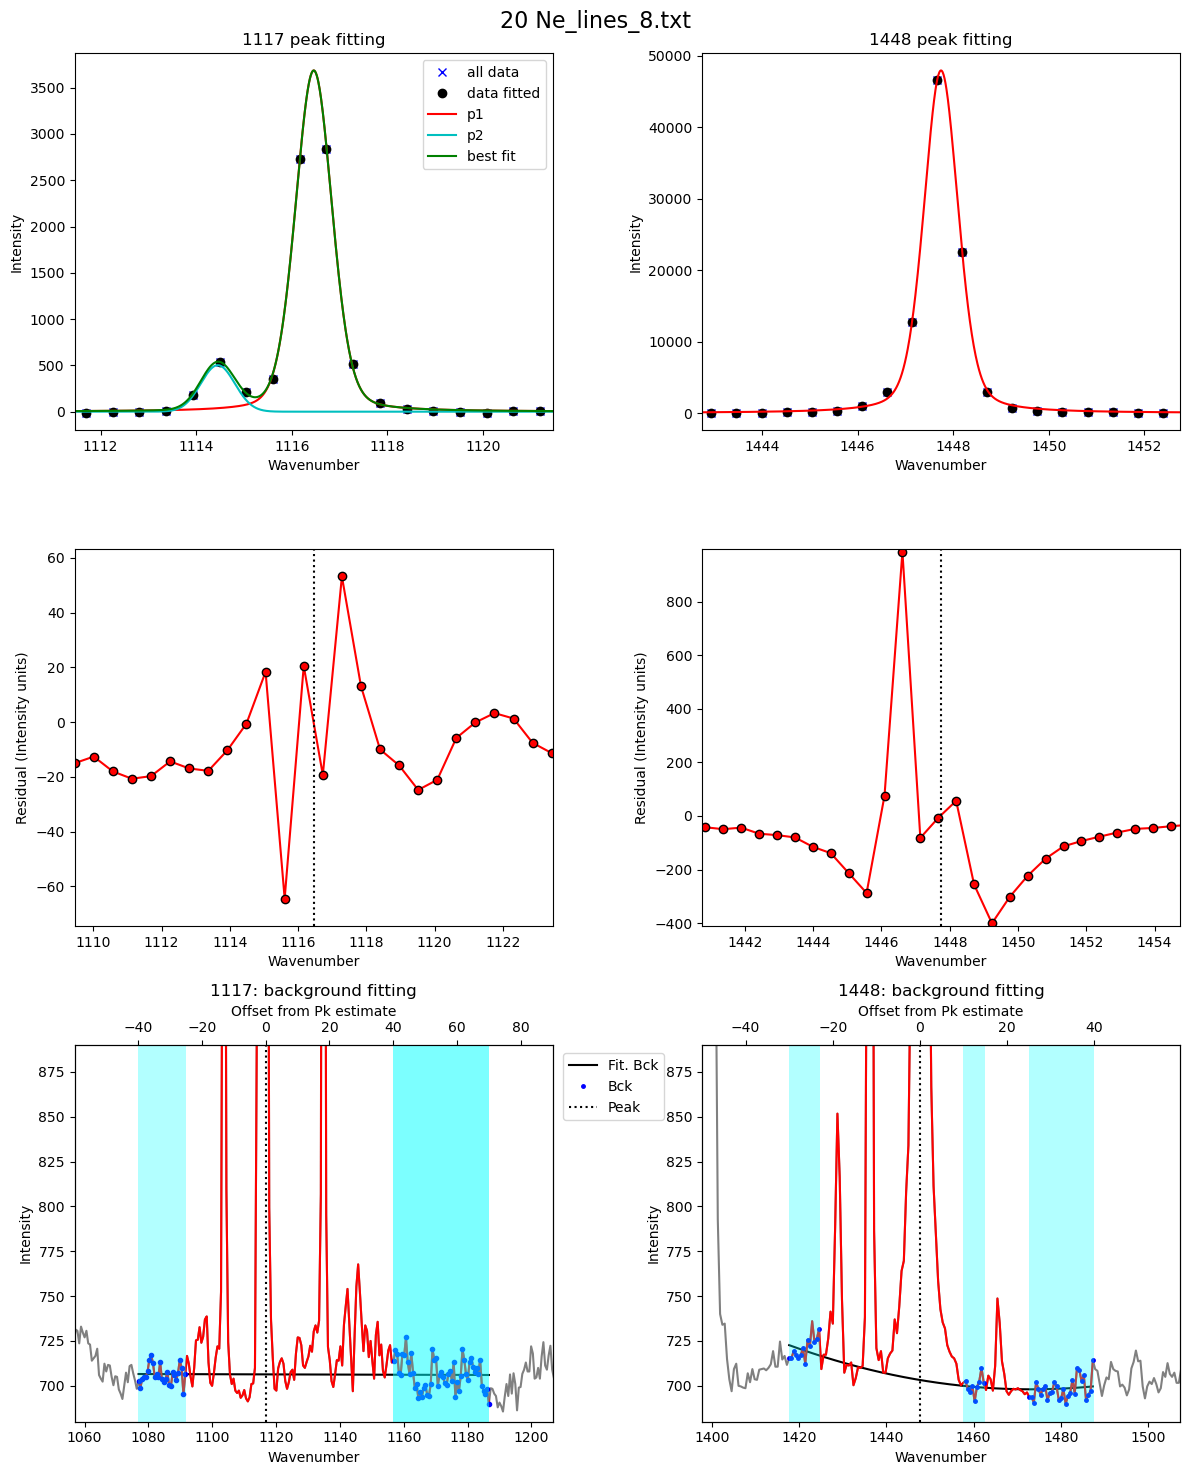

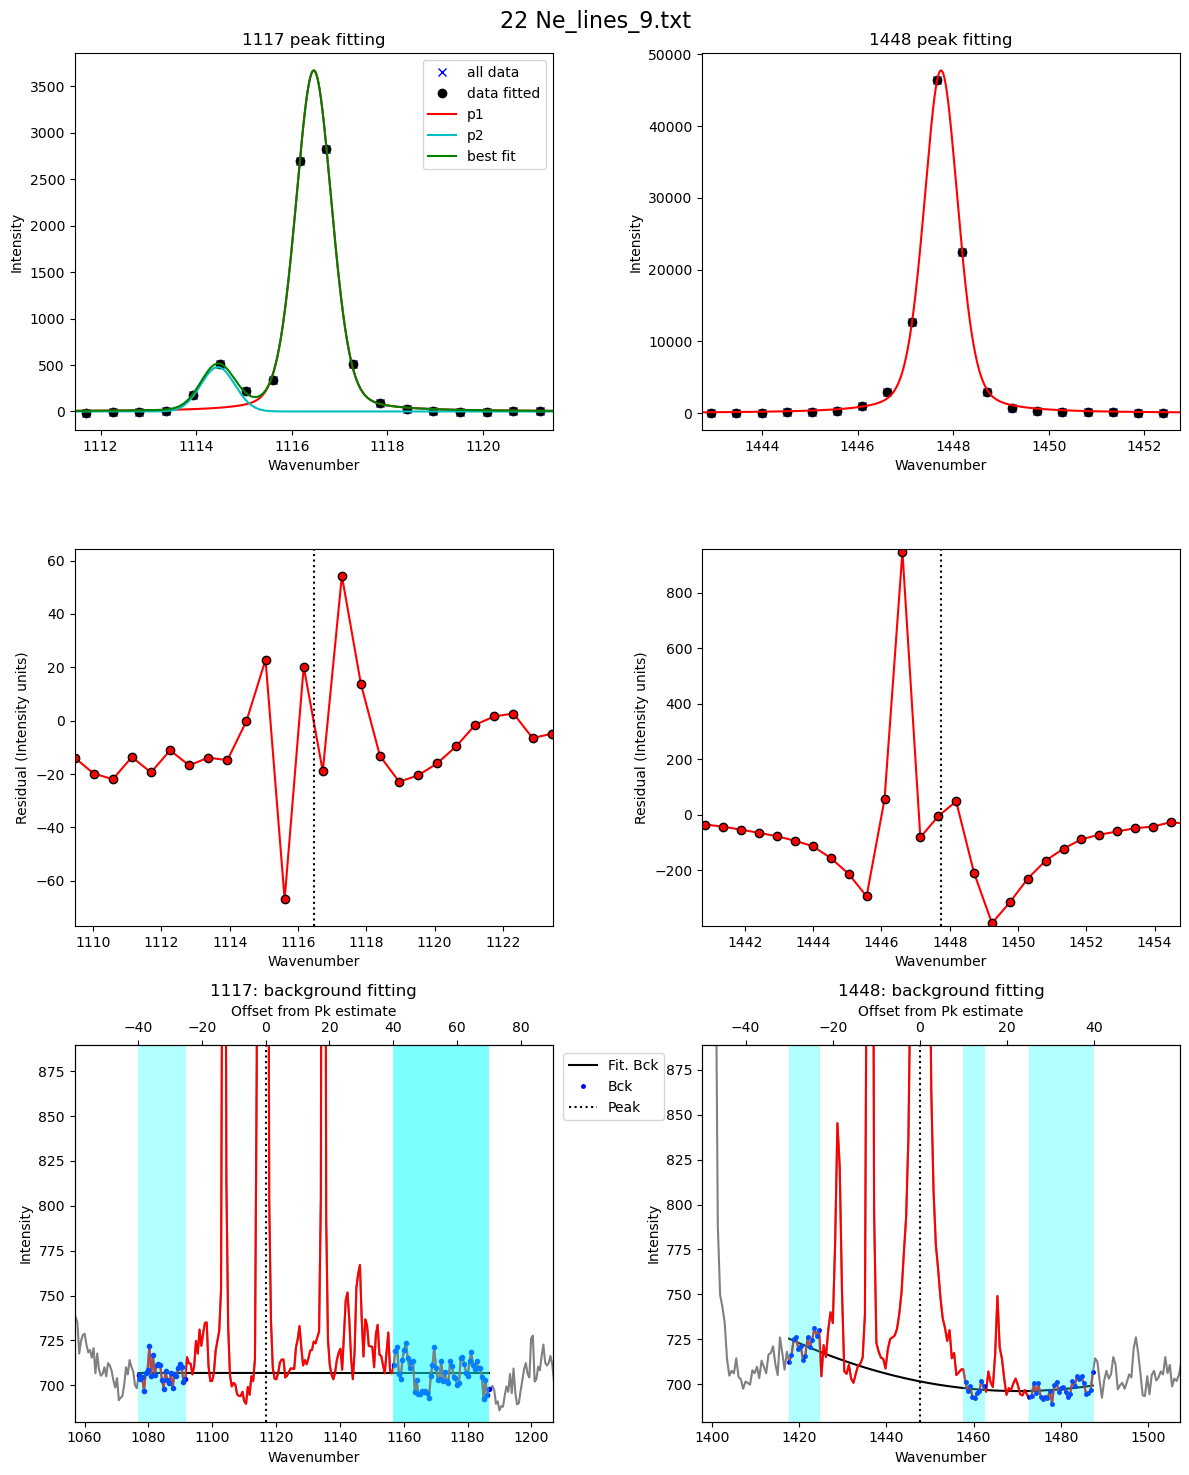

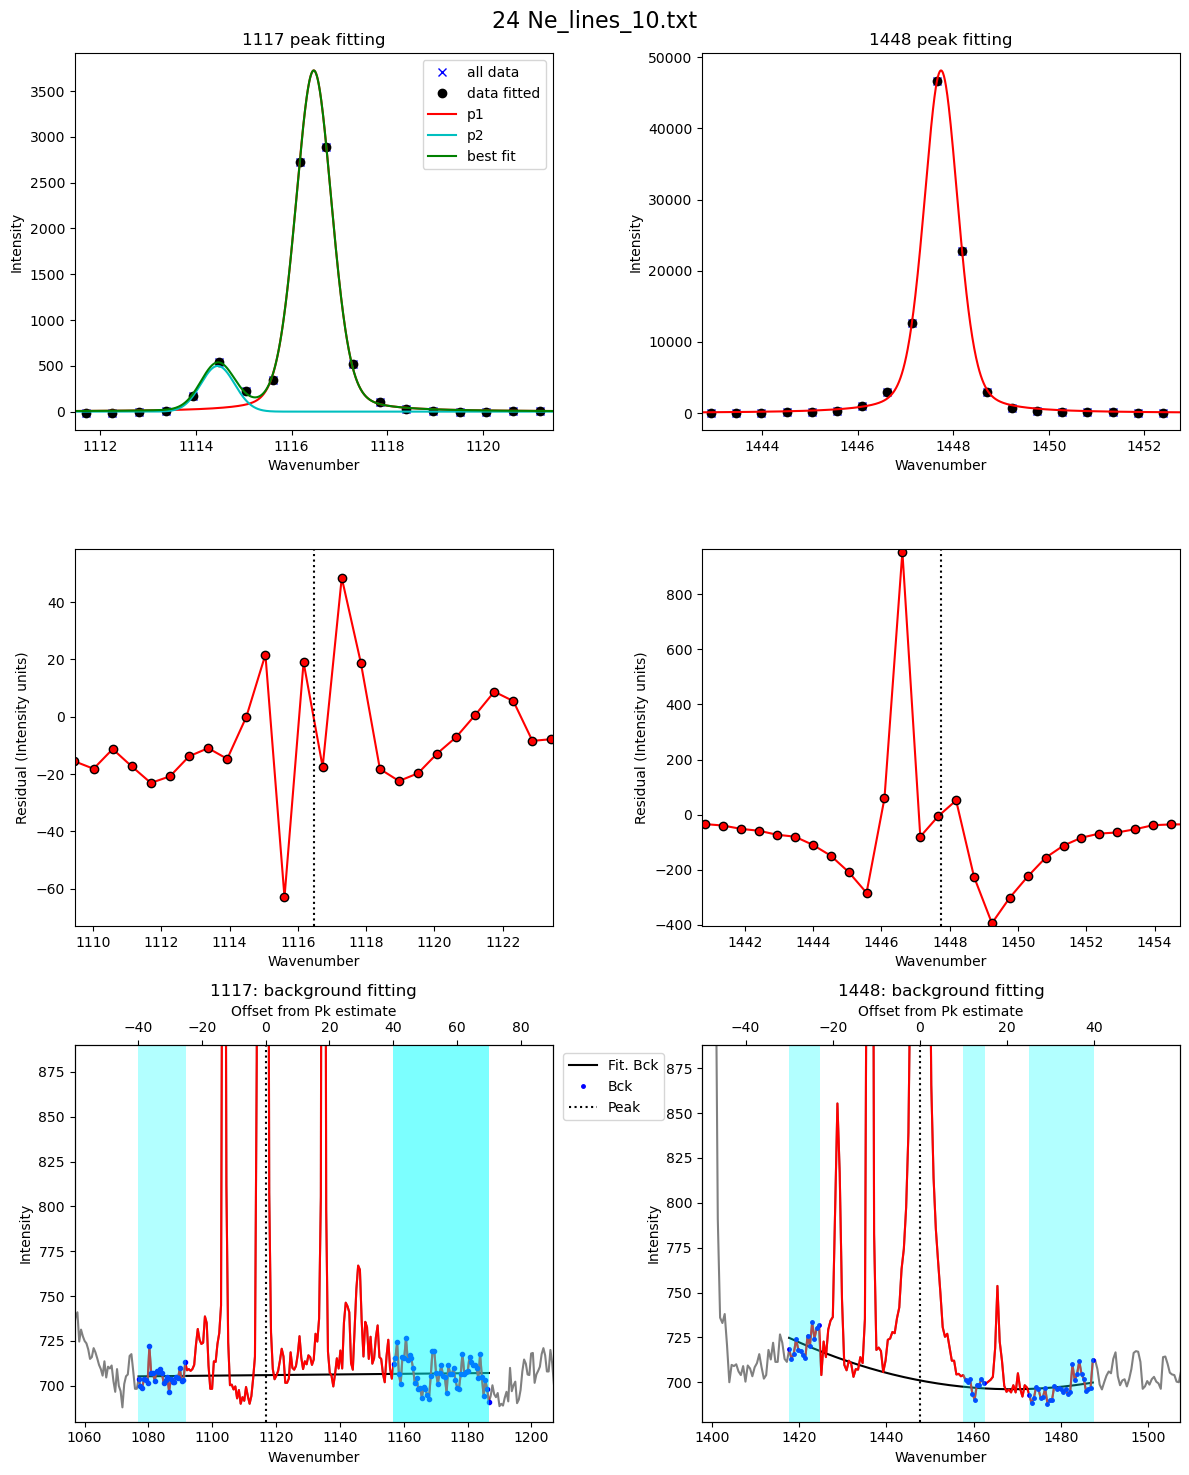

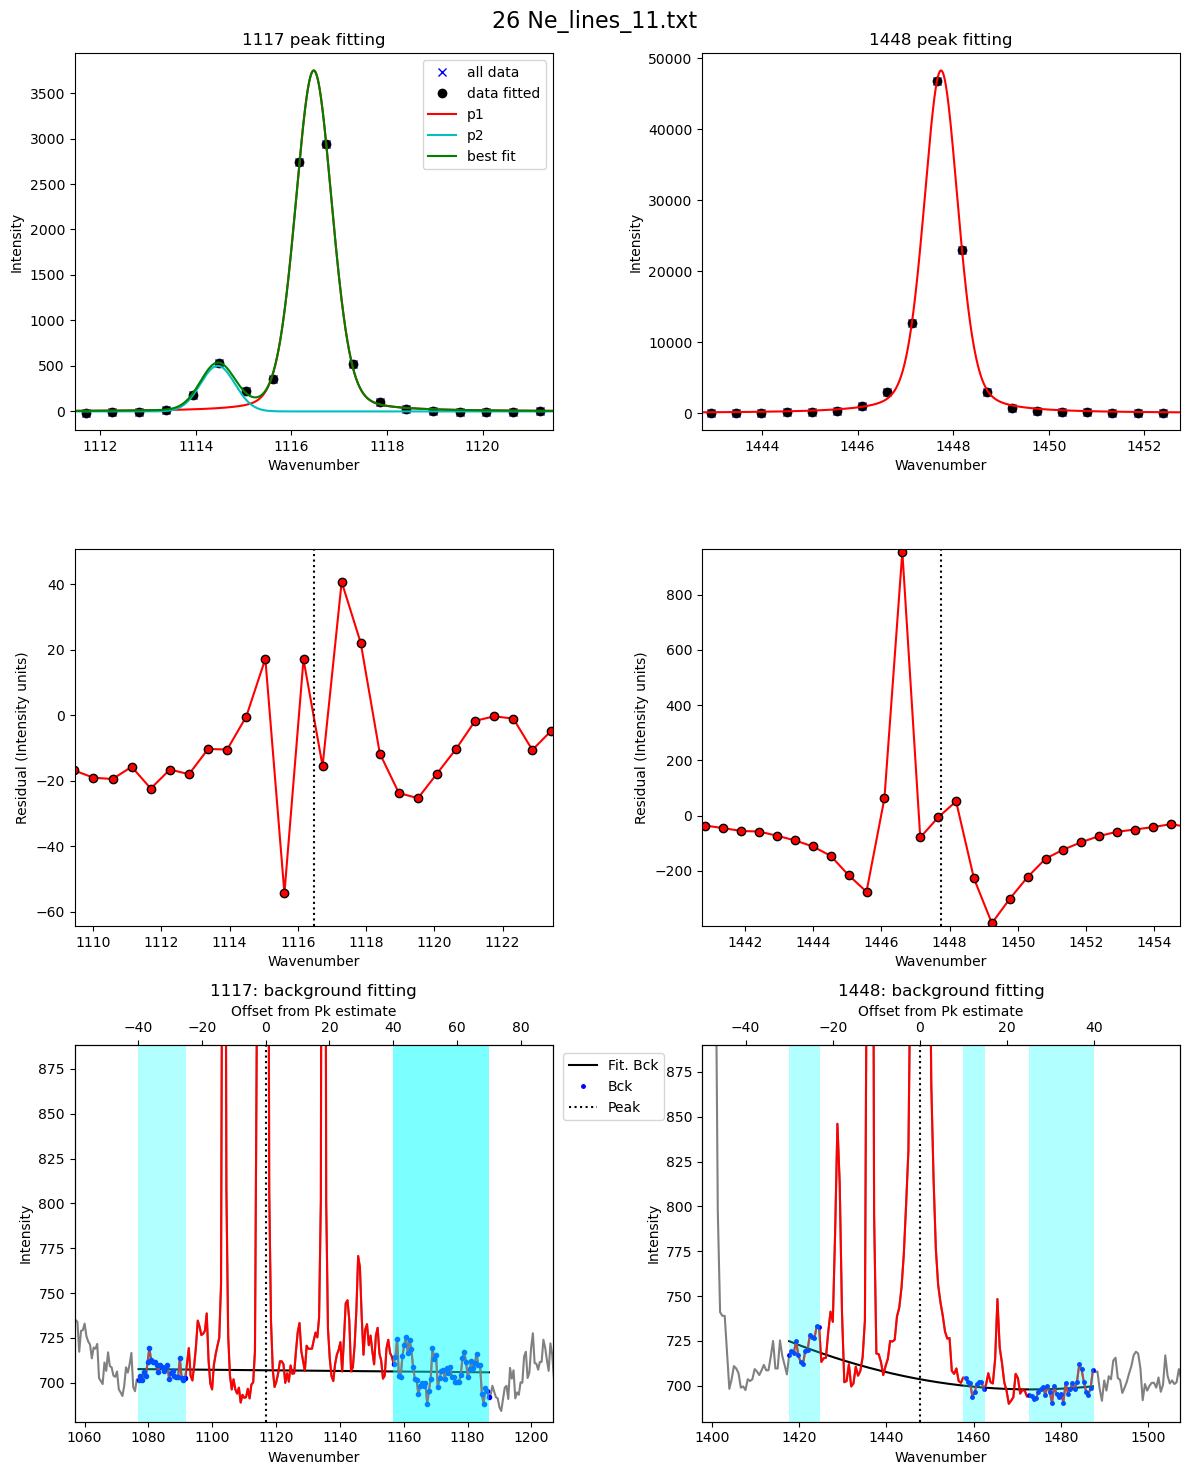

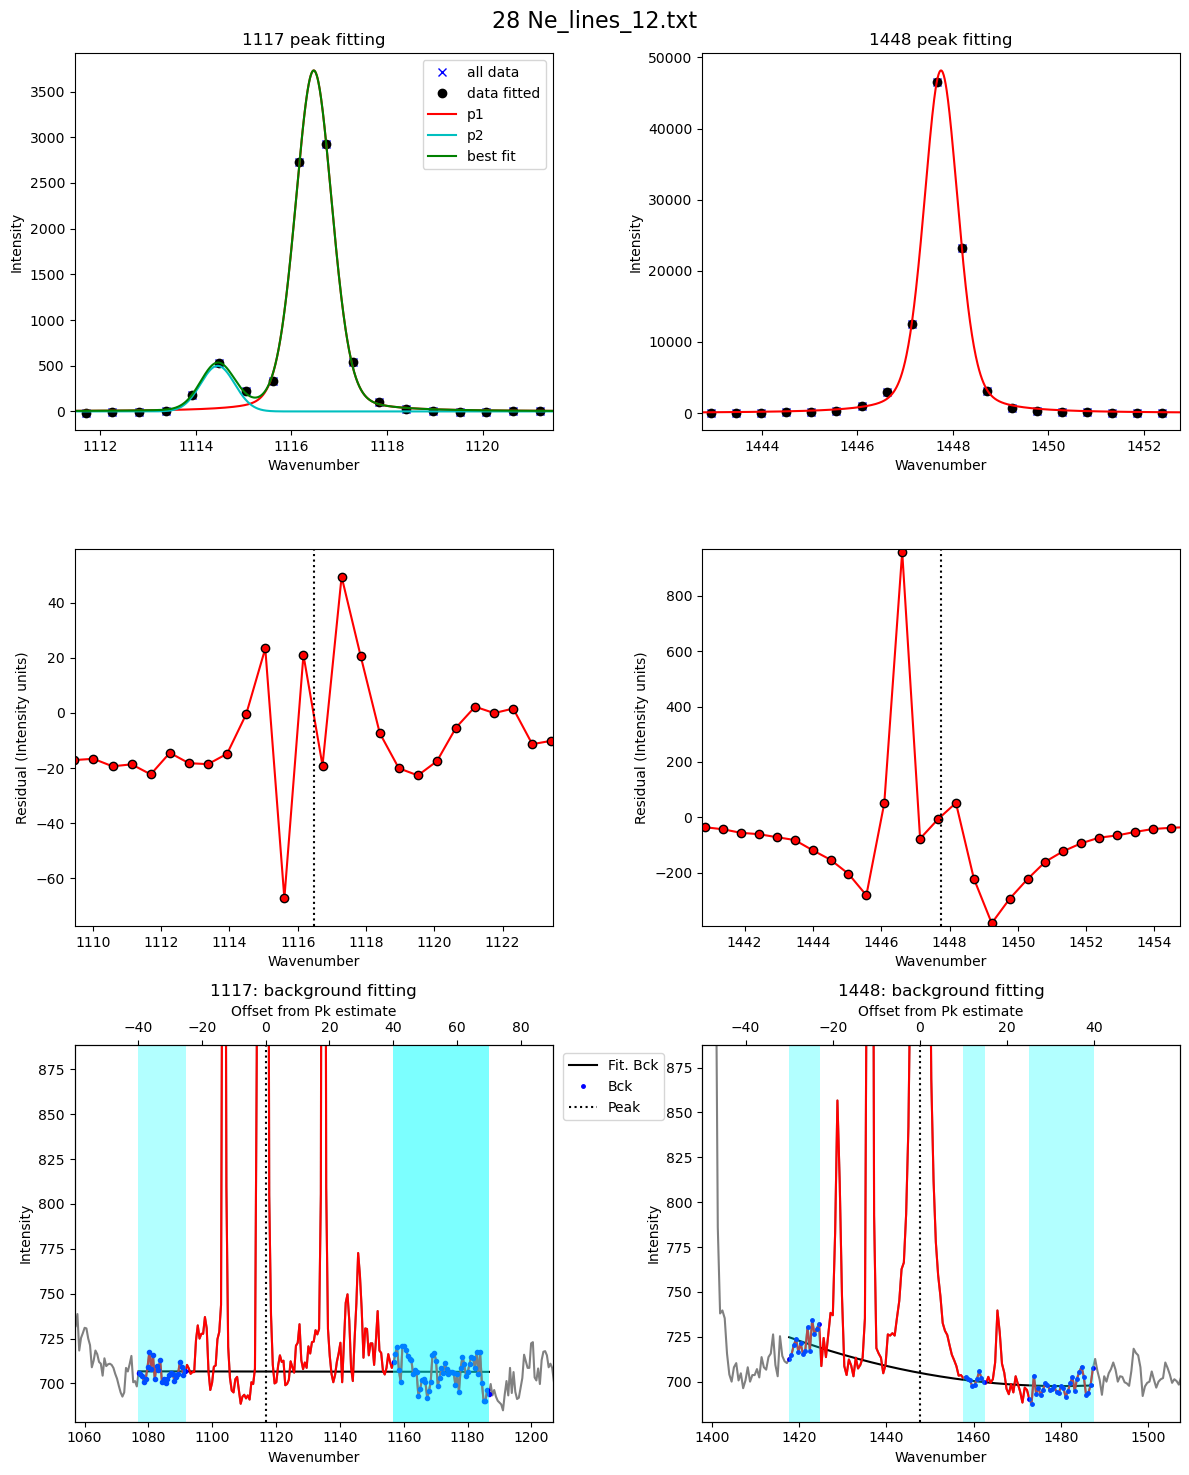

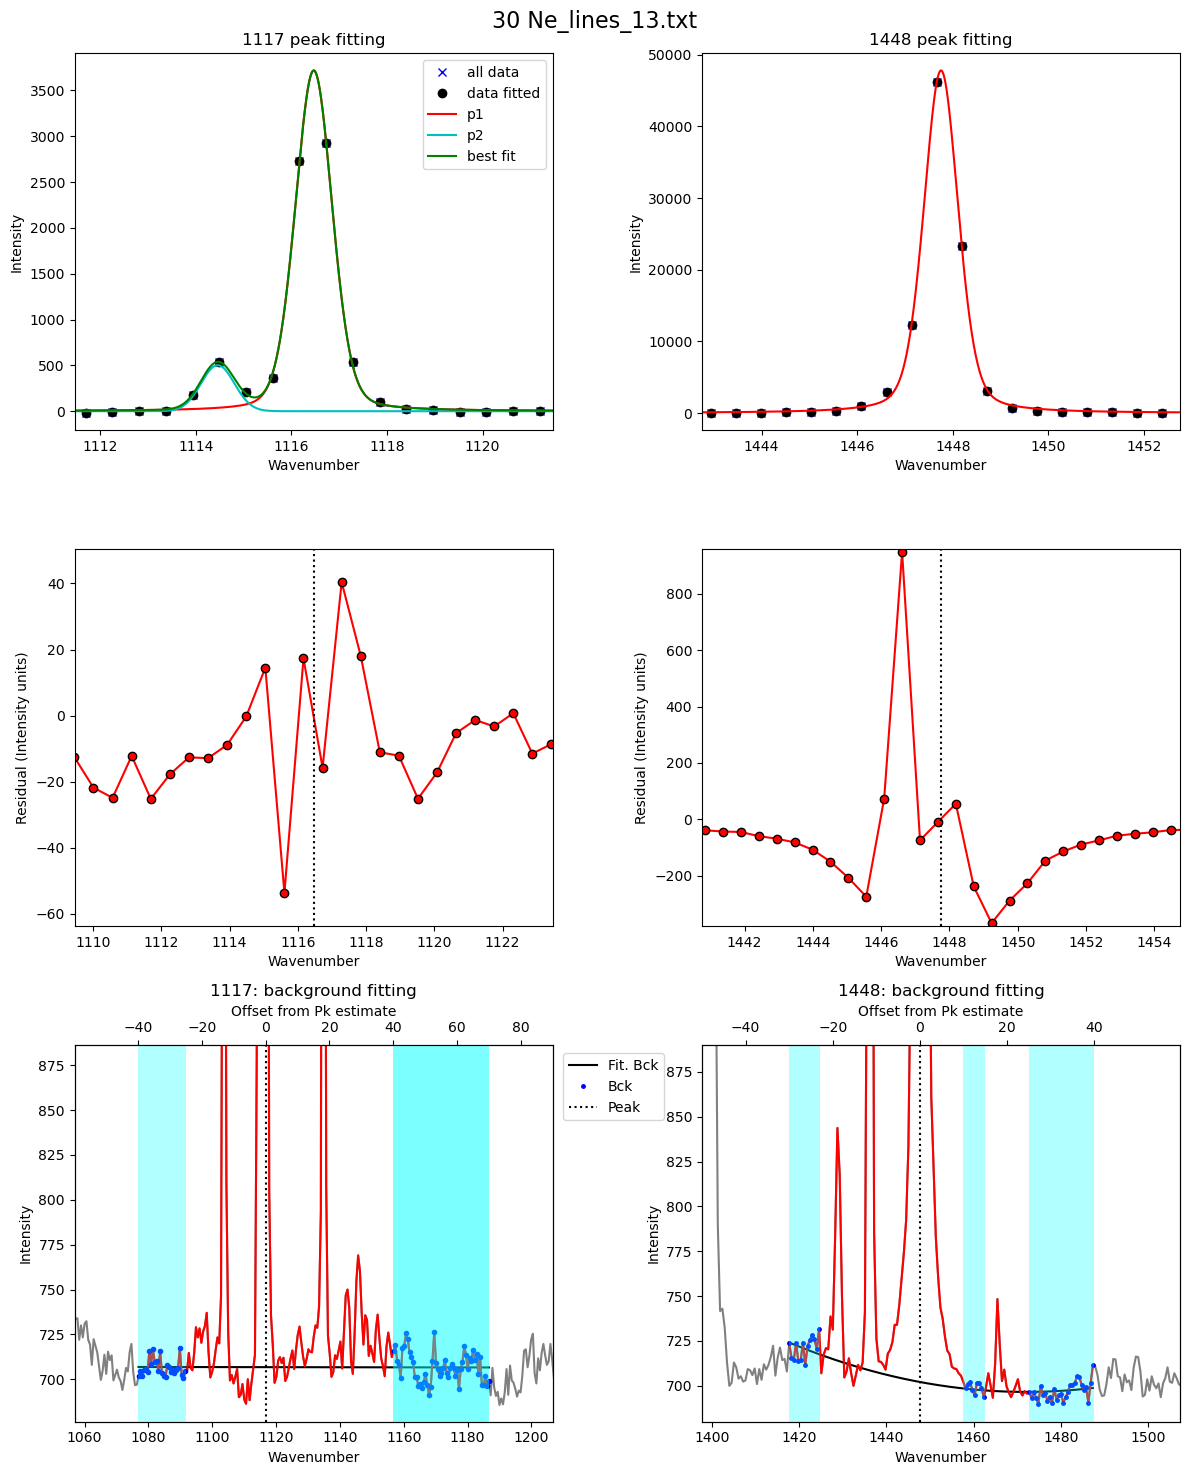

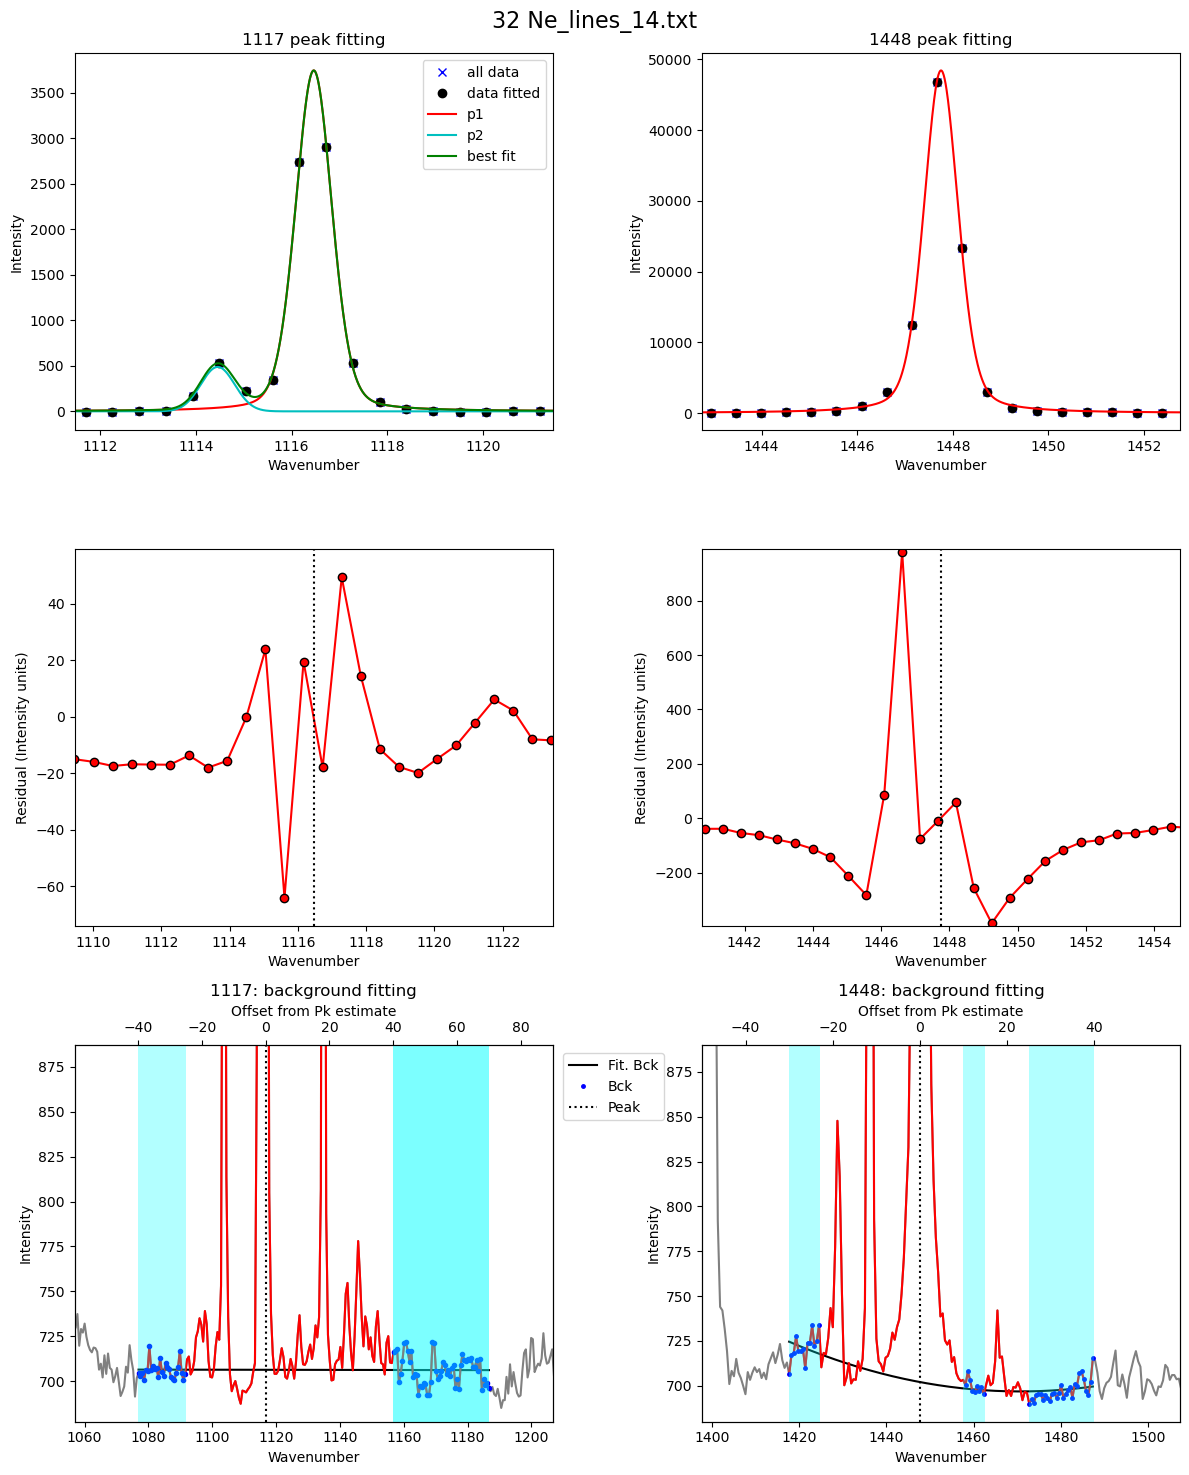

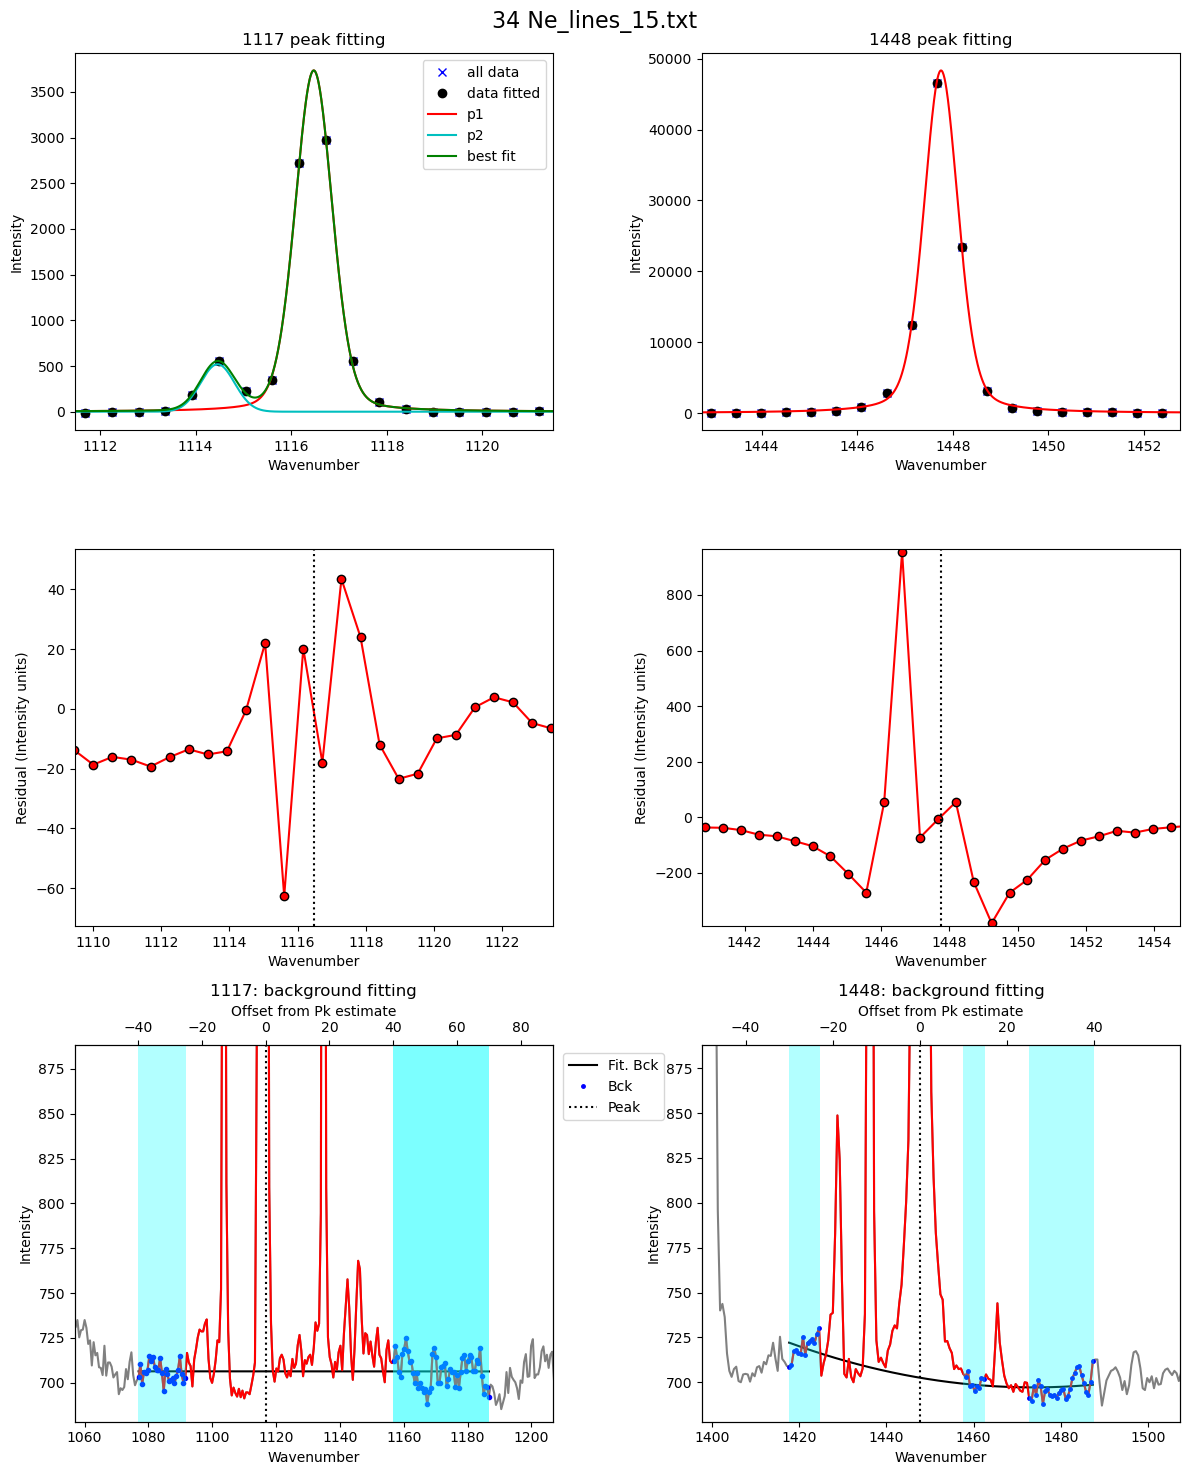

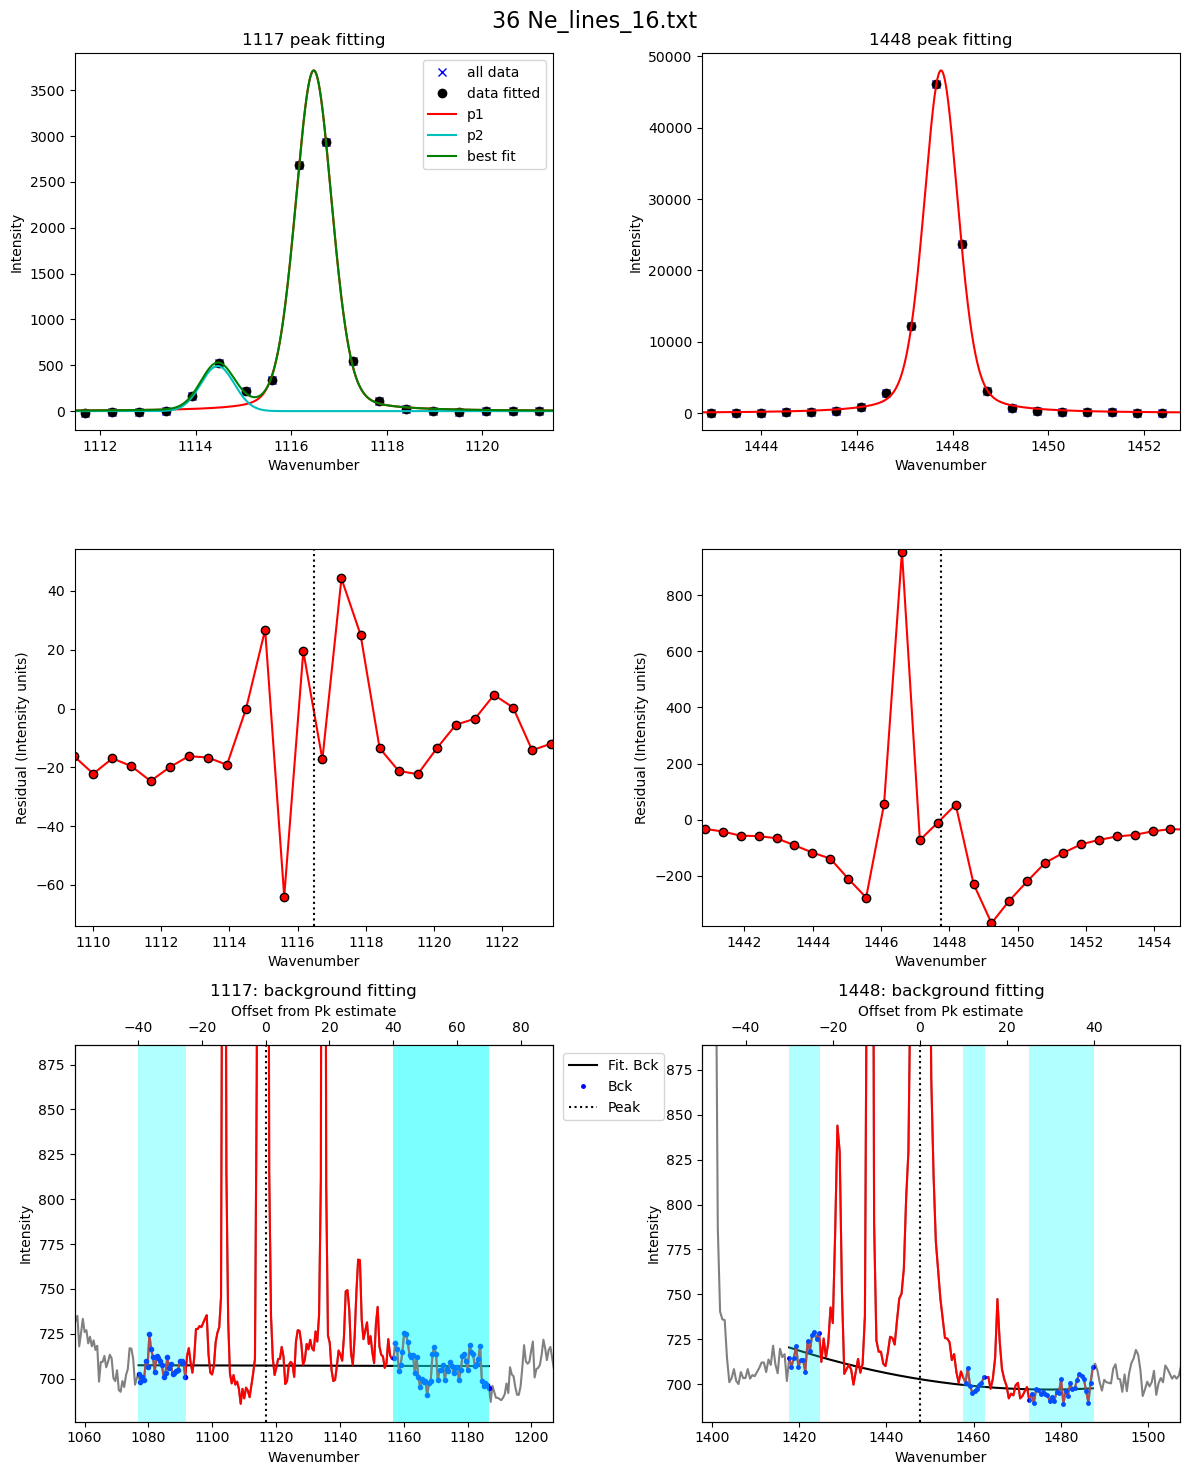

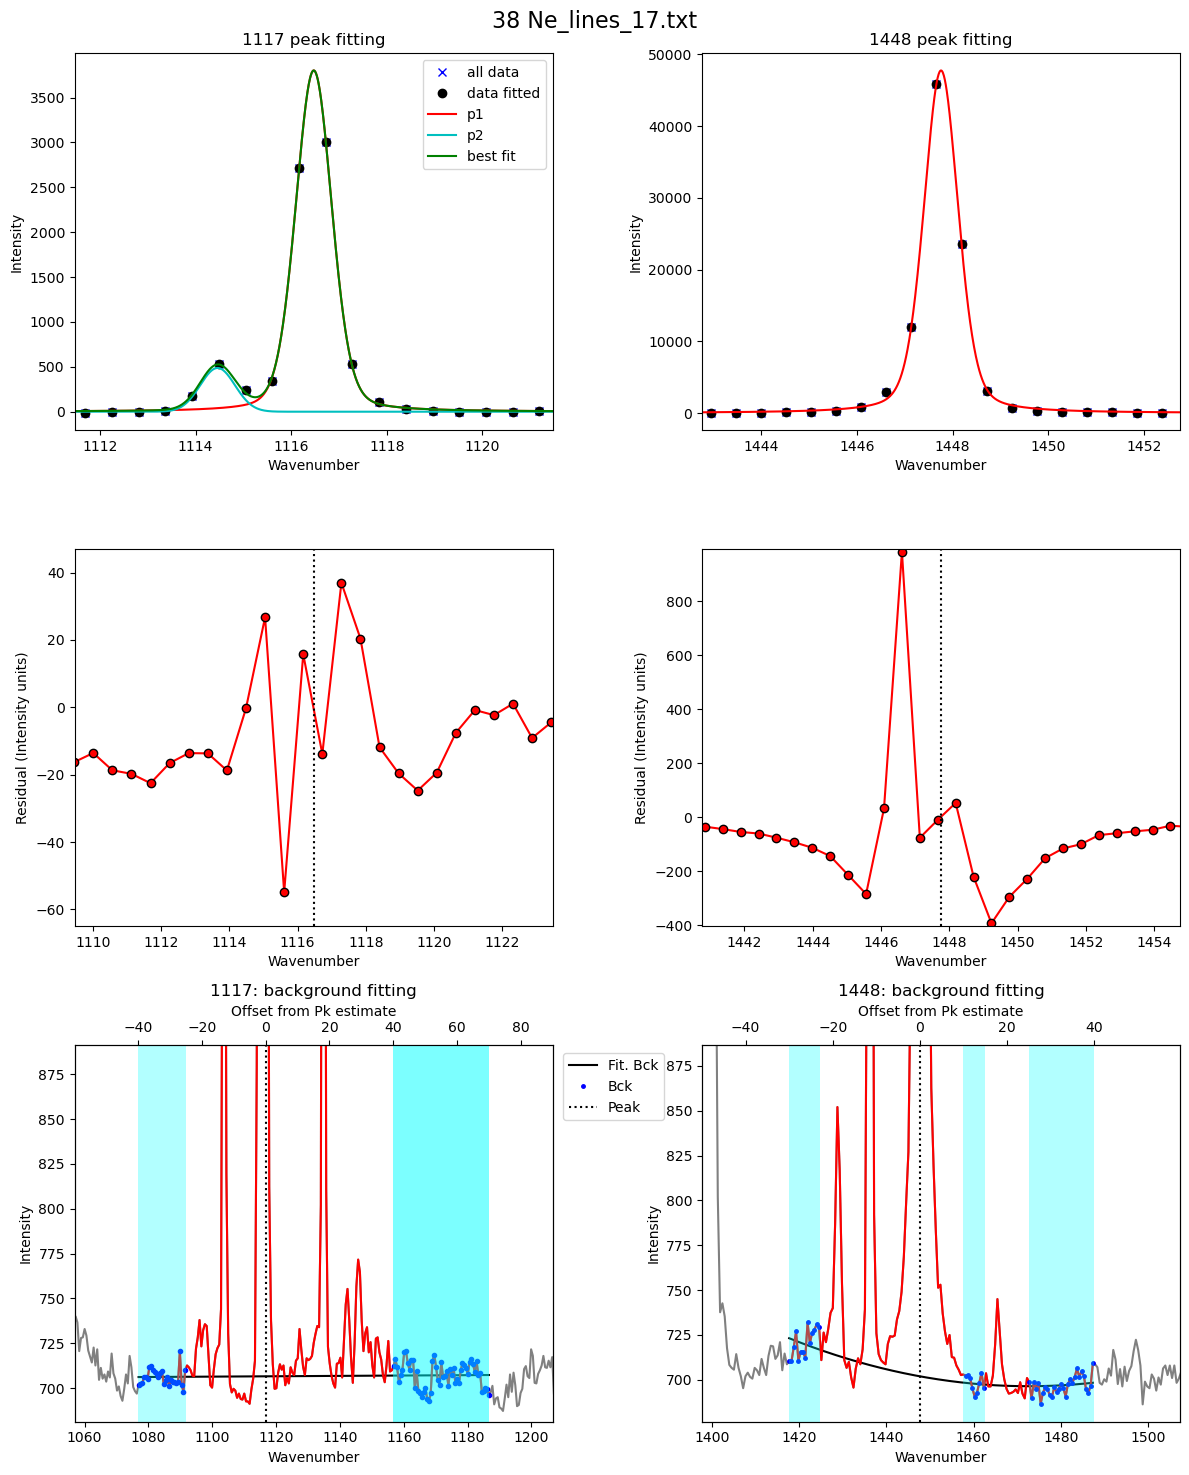

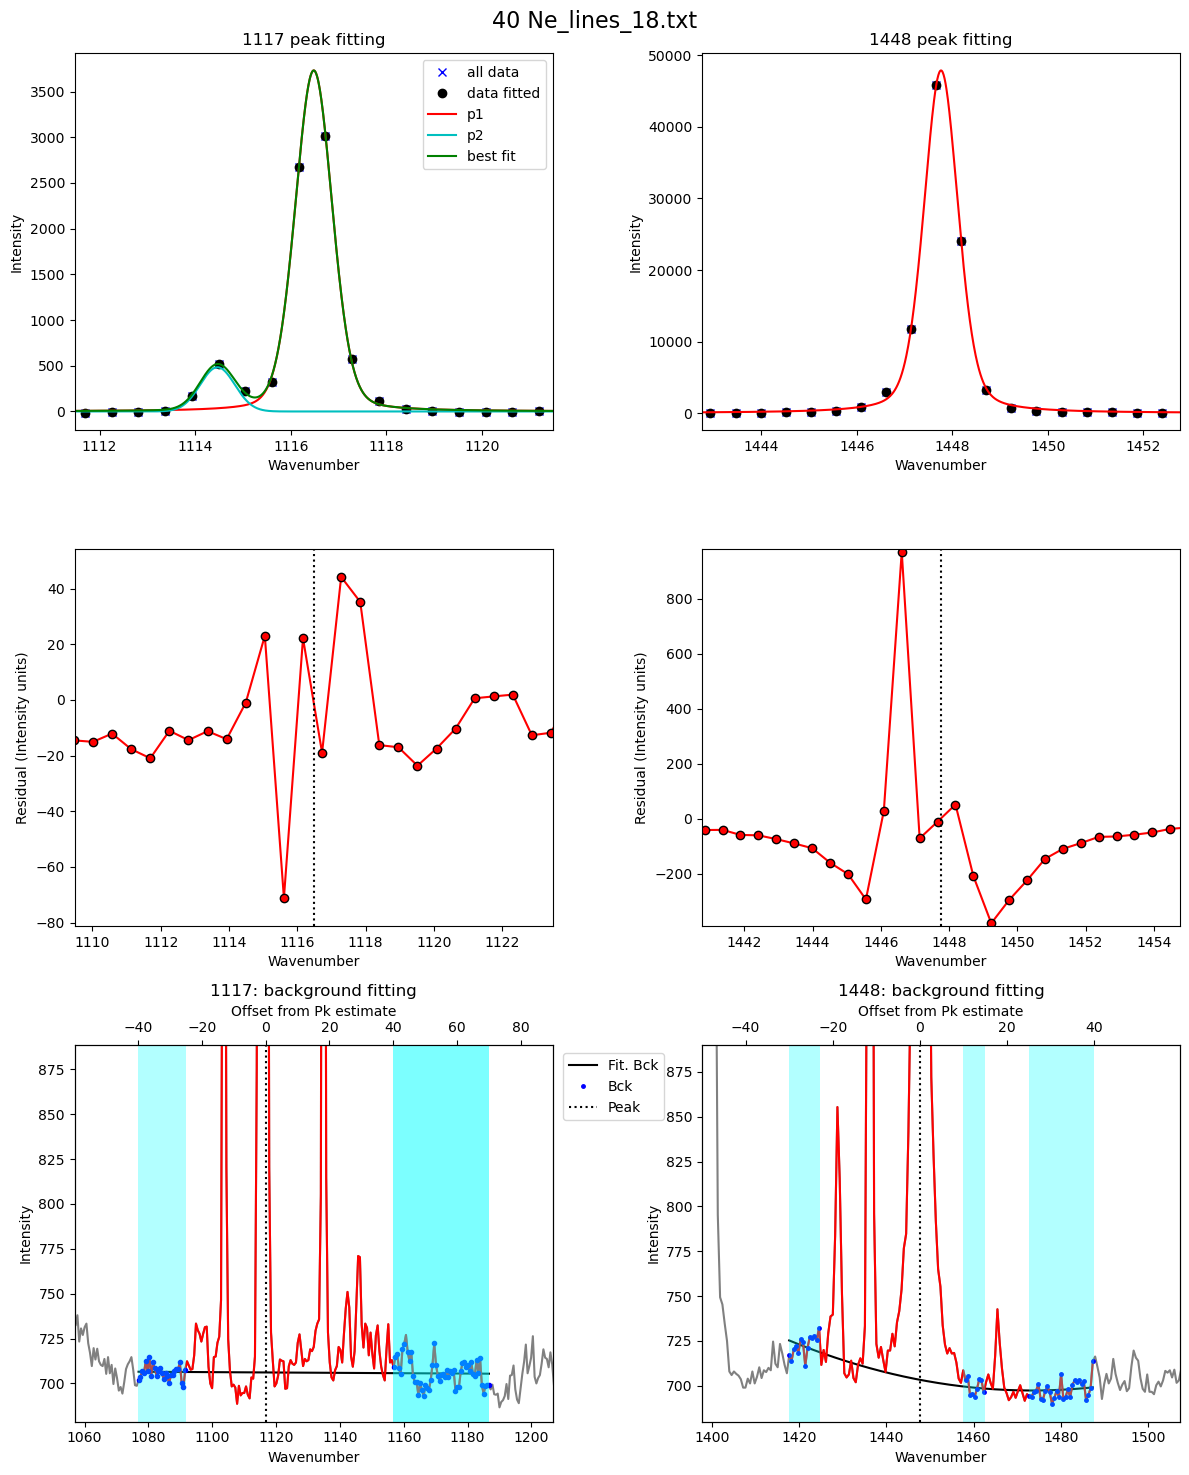

In [14]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_tweak,
df_fit_params=df_fit_params,                    
plot_figure=True)

In [17]:
df2

filename   Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0    01 Ne_lines_1.txt  0.997606  331.270579    1447.716132    1116.445553   
1    04 Ne_lines_2.txt  0.997603  331.271568    1447.727868    1116.456300   
2    08 Ne_lines_3.txt  0.997604  331.271303    1447.739093    1116.467790   
3    09 Ne_lines_4.txt  0.997598  331.273333    1447.739856    1116.466523   
4    13 Ne_lines_5.txt  0.997586  331.277446    1447.746636    1116.469189   
5    16 Ne_lines_6.txt  0.997583  331.278349    1447.741957    1116.463608   
6    18 Ne_lines_7.txt  0.997576  331.280760    1447.742753    1116.461993   
7    20 Ne_lines_8.txt  0.997562  331.285322    1447.744440    1116.459119   
8    22 Ne_lines_9.txt  0.997565  331.284398    1447.744523    1116.460126   
9   24 Ne_lines_10.txt  0.997573  331.281813    1447.745748    1116.463935   
10  26 Ne_lines_11.txt  0.997575  331.281124    1447.747180    1116.466056   
11  28 Ne_lines_12.txt  0.997568  331.283415    1447.751354    1116.467940   
12  30 Ne_lines_13.txt  0.997554  331.287896    1447.754131    1116.466236   
13  32 Ne_lines_14.txt  0.997553  331.288178    1447.752376    1116.464198   
14  34 Ne_lines_15.txt  0.997573  331.281663    1447.754195    1116.472531   
15  36 Ne_lines_16.txt  0.997559  331.286311    1447.758351    1116.472040   
16  38 Ne_lines_17.txt  0.997562  331.285275    1447.759011    1116.473736   
17  40 Ne_lines_18.txt  0.997567  331.283570    1447.764473    1116.480903   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  pk2_sigma  \
0    48954.647553    3954.602807    109.952047     14.895840   0.417475   
1    49503.913367    3800.975775    113.383165     13.536581   0.418319   
2    49163.703859    3814.912715    111.632765     14.176592   0.419602   
3    48988.316797    3821.977646    112.215137     14.767501   0.419202   
4    47789.175062    3875.782831    108.041798     15.366609   0.421864   
5    48461.388463    3844.684522    112.387039     15.037168   0.422909   
6    49285.740772    3940.628396    111.377690     15.194758   0.423506   
7    49309.037899    3894.756782    114.474640     15.471389   0.422531   
8    49167.187746    3861.188595    111.211113     15.545898   0.422171   
9    49525.504009    3922.097217    110.545117     16.027402   0.422673   
10   49613.358975    3945.180193    112.403728     15.434827   0.422991   
11   49568.909672    3932.581680    112.508769     16.080047   0.423512   
12   49295.039317    3947.481346    110.128662     14.339026   0.424712   
13   49777.623545    3954.106910    113.494467     15.785134   0.423039   
14   49659.864300    3971.624326    109.030536     15.453994   0.423426   
15   49442.575673    3935.851222    109.253473     17.041252   0.424344   
16   49230.893712    3992.623529    111.181621     15.129547   0.424126   
17   49320.999366    3959.234369    109.810690     16.279001   0.423317   

   pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0       None          1        0.390259   0.433897      None        NaN   
1       None          1        0.389533   0.442170      None        NaN   
2       None          1        0.390463   0.448795      None        NaN   
3       None          1        0.388121   0.448197      None        NaN   
4       None          1        0.388033   0.453502      None        NaN   
5       None          1        0.391518   0.447786      None        NaN   
6       None          1        0.387197   0.445760      None        NaN   
7       None          1        0.387303   0.450429      None        NaN   
8       None          1        0.393825   0.446078      None        NaN   
9       None          1        0.388433   0.447182      None        NaN   
10      None          1        0.384125   0.451408      None        NaN   
11      None          1        0.383774   0.452067      None        NaN   
12      None          1        0.382365   0.454643      None        NaN   
13      None          1        0.384157   0.448528     

## Now extract metadata to get a timestamp for each file

In [18]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='N', 
exclude_str=['diad','FDCA'], sort=False)

Ne_files_meta[0:5]

['01 Ne_lines_1.txt',
 '04 Ne_lines_2.txt',
 '08 Ne_lines_3.txt',
 '09 Ne_lines_4.txt',
 '13 Ne_lines_5.txt']

In [19]:
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=False)
meta.head()

100%|██████████| 18/18 [00:00<00:00, 583.04it/s]

Done


filename            date Month   Day  power (mW)  Int_time (s)  \
0  01 Ne_lines_1.txt  May 10, 2023\n   May  10.0         NaN          45.0   
1  04 Ne_lines_2.txt  May 10, 2023\n   May  10.0         NaN          45.0   
2  08 Ne_lines_3.txt  May 10, 2023\n   May  10.0         NaN          45.0   
3  09 Ne_lines_4.txt  May 10, 2023\n   May  10.0         NaN          45.0   
4  13 Ne_lines_5.txt  May 10, 2023\n   May  10.0         NaN          45.0   

   accumulations  Mag (X)             duration      24hr_time  \
0            3.0      5.0  ['0h', '2m', '16s']  10:23:24 AM\n   
1            3.0      5.0  ['0h', '2m', '17s']  10:34:44 AM\n   
2            3.0      5.0  ['0h', '2m', '17s']  10:56:44 AM\n   
3            3.0      5.0  ['0h', '2m', '16s']  10:59:43 AM\n   
4            3.0      5.0  ['0h', '2m', '17s']  11:33:34 AM\n   

   sec since midnight  Spectral Center  
0             37404.0         1325.004  
1             38084.0         1325.004  
2             39404.0         1325.004  
3             39583.0         1325.004  
4             41614.0         1325.004

In [20]:
# Strip away suffix and prefix if needed
print(meta['filename'][0])

01 Ne_lines_1.txt


In [21]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, str_prefix=None,
   file_type='.txt')
file_m

good job, no duplicate file names


array(['01 Ne_lines_1', '04 Ne_lines_2', '08 Ne_lines_3', '09 Ne_lines_4',
       '13 Ne_lines_5', '16 Ne_lines_6', '18 Ne_lines_7', '20 Ne_lines_8',
       '22 Ne_lines_9', '24 Ne_lines_10', '26 Ne_lines_11',
       '28 Ne_lines_12', '30 Ne_lines_13', '32 Ne_lines_14',
       '34 Ne_lines_15', '36 Ne_lines_16', '38 Ne_lines_17',
       '40 Ne_lines_18'], dtype=object)

In [22]:
# Do the same for spectra, e.g., work out what you need to strip off
print(df2['filename'][0])

01 Ne_lines_1.txt


In [23]:
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

good job, no duplicate file names


array(['01 Ne_lines_1', '04 Ne_lines_2', '08 Ne_lines_3', '09 Ne_lines_4',
       '13 Ne_lines_5', '16 Ne_lines_6', '18 Ne_lines_7', '20 Ne_lines_8',
       '22 Ne_lines_9', '24 Ne_lines_10', '26 Ne_lines_11',
       '28 Ne_lines_12', '30 Ne_lines_13', '32 Ne_lines_14',
       '34 Ne_lines_15', '36 Ne_lines_16', '38 Ne_lines_17',
       '40 Ne_lines_18'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [24]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [25]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

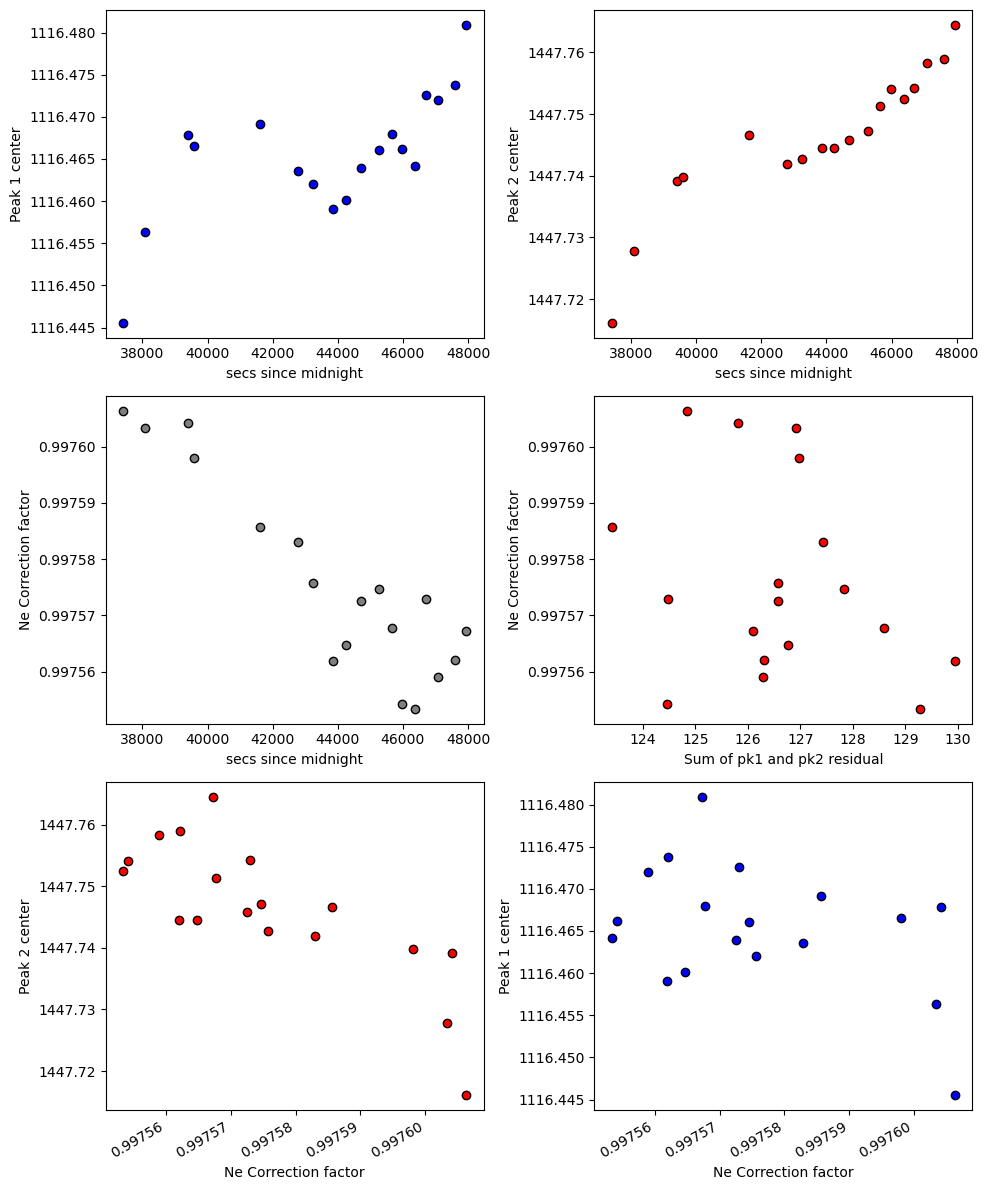

In [26]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [27]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
#df_combo_sort.to_clipboard(excel=True)
df_combo

filename_x   Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0    01 Ne_lines_1.txt  0.997606  331.270579    1447.716132    1116.445553   
1    04 Ne_lines_2.txt  0.997603  331.271568    1447.727868    1116.456300   
2    08 Ne_lines_3.txt  0.997604  331.271303    1447.739093    1116.467790   
3    09 Ne_lines_4.txt  0.997598  331.273333    1447.739856    1116.466523   
4    13 Ne_lines_5.txt  0.997586  331.277446    1447.746636    1116.469189   
5    16 Ne_lines_6.txt  0.997583  331.278349    1447.741957    1116.463608   
6    18 Ne_lines_7.txt  0.997576  331.280760    1447.742753    1116.461993   
7    20 Ne_lines_8.txt  0.997562  331.285322    1447.744440    1116.459119   
8    22 Ne_lines_9.txt  0.997565  331.284398    1447.744523    1116.460126   
9   24 Ne_lines_10.txt  0.997573  331.281813    1447.745748    1116.463935   
10  26 Ne_lines_11.txt  0.997575  331.281124    1447.747180    1116.466056   
11  28 Ne_lines_12.txt  0.997568  331.283415    1447.751354    1116.467940   
12  30 Ne_lines_13.txt  0.997554  331.287896    1447.754131    1116.466236   
13  32 Ne_lines_14.txt  0.997553  331.288178    1447.752376    1116.464198   
14  34 Ne_lines_15.txt  0.997573  331.281663    1447.754195    1116.472531   
15  36 Ne_lines_16.txt  0.997559  331.286311    1447.758351    1116.472040   
16  38 Ne_lines_17.txt  0.997562  331.285275    1447.759011    1116.473736   
17  40 Ne_lines_18.txt  0.997567  331.283570    1447.764473    1116.480903   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  pk2_sigma  ...  \
0    48954.647553    3954.602807    109.952047     14.895840   0.417475  ...   
1    49503.913367    3800.975775    113.383165     13.536581   0.418319  ...   
2    49163.703859    3814.912715    111.632765     14.176592   0.419602  ...   
3    48988.316797    3821.977646    112.215137     14.767501   0.419202  ...   
4    47789.175062    3875.782831    108.041798     15.366609   0.421864  ...   
5    48461.388463    3844.684522    112.387039     15.037168   0.422909  ...   
6    49285.740772    3940.628396    111.377690     15.194758   0.423506  ...   
7    49309.037899    3894.756782    114.474640     15.471389   0.422531  ...   
8    49167.187746    3861.188595    111.211113     15.545898   0.422171  ...   
9    49525.504009    3922.097217    110.545117     16.027402   0.422673  ...   
10   49613.358975    3945.180193    112.403728     15.434827   0.422991  ...   
11   49568.909672    3932.581680    112.508769     16.080047   0.423512  ...   
12   49295.039317    3947.481346    110.128662     14.339026   0.424712  ...   
13   49777.623545    3954.106910    113.494467     15.785134   0.423039  ...   
14   49659.864300    3971.624326    109.030536     15.453994   0.423426  ...   
15   49442.575673    3935.851222    109.253473     17.041252   0.424344  ...   
16   49230.893712    3992.623529    111.181621     15.129547   0.424126  ...   
17   49320.999366    3959.234369    109.810690     16.279001   0.423317  ...   

   Month   Day  power (mW)  Int_time (s) accumulations  Mag (X)  \
0    May  10.0         NaN          45.0           3.0      5.0   
1    May  10.0         NaN          45.0           3.0      5.0   
2    May  10.0         NaN          45.0           3.0      5.0   
3    May  10.0         NaN          45.0           3.0      5.0   
4    May  10.0         NaN          45.0           3.0      5.0   
5    May  10.0         NaN          45.0           3.0      5.0   
6    May  10.0         NaN          45.0           3.0      5.0   
7    May  10.0         NaN          45.0           3.0      5.0   
8    May  10.0         NaN          45.0           3.0      5.0   
9    May  10.0         NaN          45.0           3.0      5.0   
10   May  10.0         NaN          45.0           3.0      5.0   
11   May  10.0         NaN          45.0           3.0      5.0   
12   May  10.0         NaN          45.0           3.0      5.0   
13   May  10.0         NaN          45.0           3.0      5.0   
14 

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right

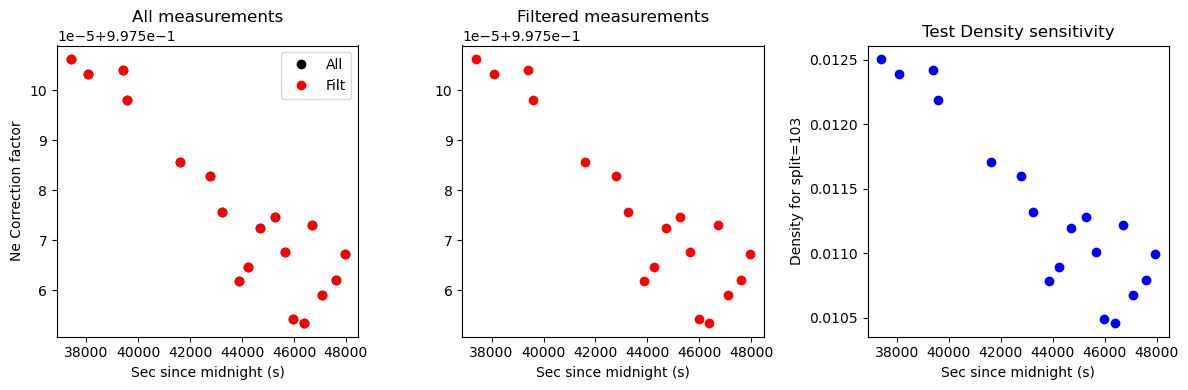

In [28]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], 
                    number_av=5, offset=0.0005)
# Now lets plot this to see
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')


ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')
ax2.set_xlabel('Sec since midnight (s)')
ax2.set_title('Filtered measurements')
ax3.set_xlabel('Sec since midnight (s)')
ax3.set_ylabel('Density for split=' + str(test_split))
ax3.set_title('Test Density sensitivity')
fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

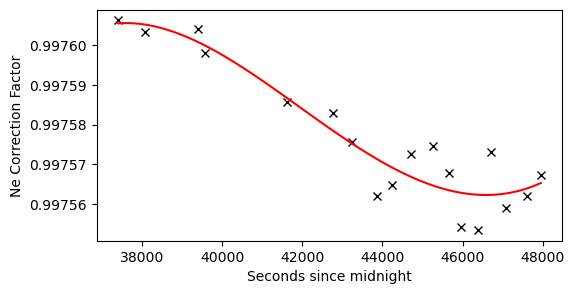

In [37]:
df_combo_filt=df_combo[density_test['Preferred D']>0]

N_poly=4
fit='poly'

model, fig=pf.reg_Ne_lines_time(df=df_combo_filt, N_poly=N_poly, fit=fit)

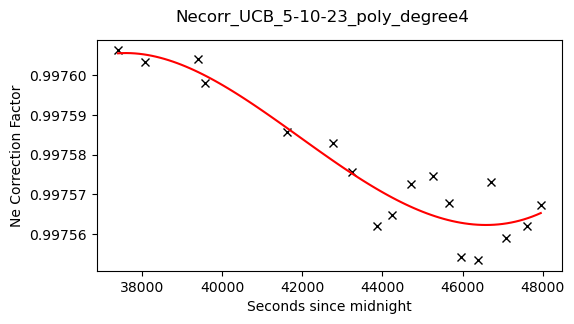

In [38]:
#Export Ne fits to excel
nm=os.path.basename(DayFolder)
model_short=''.join(char for char in model_name if char.isupper()) # this extracts the capital letters from the model name, example: PseudoVoigtModel=PVM

df_combo_sort.to_excel(fitout_path+'/'+"Ne_"+nm+"_"+model_short+".xlsx")

fig.suptitle('Necorr_'+nm+"_"+fit+'_degree'+str(N_poly))
fig.savefig(fitout_path+'/'+'Necorr_'+nm+"_"+fit+'_degree'+str(N_poly)+".png")
fig

## SAving as pickle, can then load as a pickle

In [39]:
import pickle

with open(output_path+'\Pickles'+'/'+'Ne_lineReg_'+nm+'_'+model_short+'.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)
print('done')

done
